<a href="https://colab.research.google.com/github/jo-cho/advances_in_financial_machine_learning/blob/master/Bet%20Sizing/Bet_sizing_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BET SIZING

This notebook is based on the book *Advances in Financial Machine Learning* by Lopez De Prado. (Chapter 3 and Chapter 10)

# IMPORT LIB

In [0]:
# lib
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

In [0]:
# sklearn

from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics

In [0]:
!pip install -q ta
import ta

In [0]:
import warnings
warnings.filterwarnings(action='ignore')

In [265]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [266]:
# Big thanks to mlfinlab!

!pip install mlfinlab
from mlfinlab import data_structures, features, filters, labeling, util, sampling, cross_validation

# 1. Bet sizing (probability) - applying meta-labeling

We fit a
classifier, such as an SVC or RF, to determine the probability of misclassification, and
use that probability to derive the bet size.

### WHY do we use meta-labeling for sizing the bet?

Advantages
1. The ML algorithm that decides the bet sizes is independent of the primary model, allowing for the incorporation of features predictive of false positives (see below). 

2. The predicted probability can be directly translated into bet size.

### What is meta labeling?

Suppose that you have a model for setting the side of the bet (long or short). You just need to learn the size of that bet, which includes the possibility of no bet at all (zero size). This is a situation that practitioners face regularly. We often know whether we want to buy or sell a product, and the only remaining question is **how much money we should risk in such a bet**. We do not want the ML algorithm to learn the side, just
to tell us what is the **appropriate size**. We want to build a **secondary ML model** that learns how to use a primary exogenous model.

Binary classification problems present a trade-off between type-I errors (false positives) and type-II errors (false negatives). In general, increasing the true positive rate of a binary classifier will tend to increase its false positive rate. The receiver operating characteristic (ROC) curve of a binary classifier measures the cost of increasing the true positive rate, in terms of accepting higher false positive rates.

Meta-labeling is particularly helpful when you want to achieve higher F1-scores. First, we build a model that achieves high recall, even if the precision is not particularly high. Second, we correct for the low precision by applying meta-labeling to the positives predicted by the primary model.

Meta-labeling will increase your F1-score by filtering out the false positives, where the majority of positives have already been identified by the primary model. Stated differently, the role of the secondary ML algorithm is to determine whether a positive from the primary (exogenous) model is true or false. It is not its purpose to come up with a betting opportunity. Its purpose is to determine **whether we should act or pass
on the opportunity that has been presented.**



Advantages of meta-labeling

First, ML algorithms are often criticized as black boxes.
Meta-labeling allows you to build an ML system on top of a white box (like a fundamental model founded on economic theory). This ability to transform a fundamental model into an ML model should make meta-labeling particularly useful to “quantamental” firms. 

Second, the effects of overfitting are limited when you apply meta labeling,
because ML will not decide the side of your bet, only the size. 

Third, by decoupling the side prediction from the size prediction, meta-labeling enables sophisticated strategy structures. For instance, consider that the features driving a rally may differ from the features driving a sell-off. In that case, you may want to develop an
ML strategy exclusively for long positions, based on the buy recommendations of a primary model, and an ML strategy exclusively for short positions, based on the sell recommendations of an entirely different primary model. 

Fourth, achieving high accuracy on small bets and low accuracy on large bets will ruin you. As important as identifying good opportunities is to size them properly, so it makes sense to develop an ML algorithm solely focused on getting that critical decision (sizing) right. - Bet Sizing

Four steps


1. Use your forecasts from the primary model, and generate meta-labels. Remember, horizontal barriers do not need to be symmetric in this case.

2. Fit your model again on the same training set, but this time using the meta-labels you just generated.

3. Combine the “sides” from the first ML model with the “sizes” from the second ML model. I.e. if your primary model predicts a 3 and your secondary model says you have a high probability of the primary model being correct, is your final prediction a 3, else not 3.

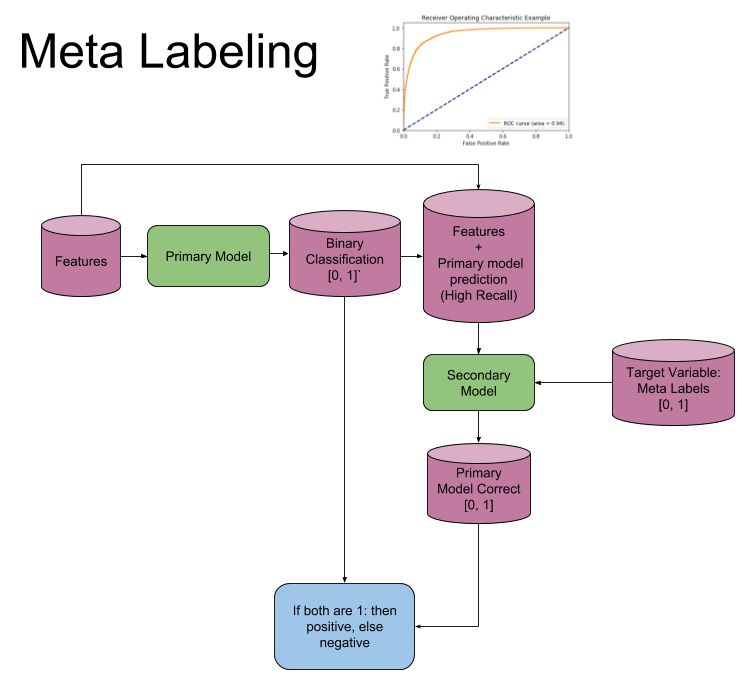

In [267]:
from IPython.core.display import Image
Image(filename='/content/drive/My Drive/Colab Notebooks/images/meta-labeling.png')

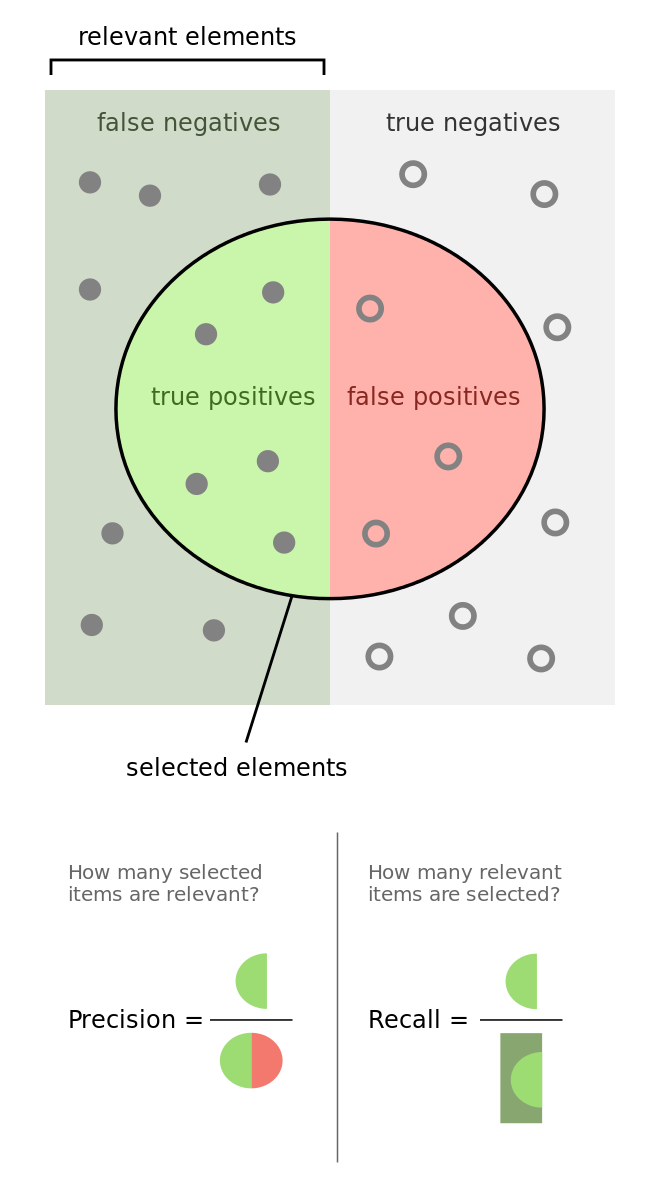

In [268]:
Image(filename='/content/drive/My Drive/Colab Notebooks/images/f1.png')

### Steps 


https://hudsonthames.org/does-meta-labeling-add-to-signal-efficacy-triple-barrier-method/

1. Compute long short signals for the strategy. For instance, in the mean-reverting strategy, generate a long signal when the close price is below the lower Bollinger band and create a sell signal if the close price is higher than the upper Bollinger band. We call this the “Primary model”.

2. Get time stamps of the events using CUSUM (or cumulative sum control chart) filter and point estimate of the volatility. See section 4.2.
Determine events when one of the three exit points (profit taking, stop-loss and vertical barrier) occur. Advances in Financial Machine Learning discusses this in Chapter 3. The result of this step is a trade decision – long or short, or 1 or -1.

3. Determine the bet size. The prior step tell us the direction of the trade. This step says if we should trade or not – a one or zero decision.
Tune the hyper-parameters (max_depth and n_estimators) of Random Forest using grid search and cross-validation. We keep the random state constant for reproducibility of the results.

4. Train a machine-learning algorithm (we use Random Forest for illustration) with new features like one to five day serial correlations, one to five-day returns, 50-day volatility, and 14-day RSI. We iterate over this step number of times until we see in-sample results that are acceptable. In other words, we only exit this step when we consider the model to be ready and there is no turning back.

5. Evaluate the performance of in sample and out-of-sample or this meta-model model.
Evaluate the performance of the “Primary model”
Compare the performance of the meta-model and the primary model

## Read in data - dollar bars

E-mini S&P Future tick data

In [269]:
# make dollar bars from tick data
threshold = 200_000
raw_dollar_bars = data_structures.get_dollar_bars('/content/drive/My Drive/Colab Notebooks/csv/clean_IVE_tickbidask2.csv', threshold=threshold)
dollar_bars = raw_dollar_bars.set_index(pd.to_datetime(raw_dollar_bars.date_time))
dollar_bars = dollar_bars.drop(columns='date_time')
dollar_bars = dollar_bars.reset_index().drop_duplicates(subset='date_time', keep='last').set_index('date_time')

Reading data in batches:
Batch number: 0
Returning bars 



In [270]:
dollar_bars.head()

tick_num   open  ...  cum_ticks  cum_dollar_value
date_time                             ...                             
2009-09-28 09:33:08        14  50.79  ...         14       210018.6000
2009-09-28 09:40:44        32  50.81  ...         18       203668.6338
2009-09-28 09:44:24        45  50.80  ...         13       203577.0000
2009-09-28 09:46:34        60  51.00  ...         15       245058.0000
2009-09-28 09:46:35        63  51.07  ...          3       316634.0000

[5 rows x 9 columns]

In [271]:
len(dollar_bars)

217520

In [0]:
close = dollar_bars.close

Why do we use dollar bars?

See Chapter 2

## 1. Train a primary model (which decides 'sides') 

### First Option
- Based on the simple moving average cross-over strategy.

In [0]:

fast_window = 20
slow_window = 50

df = pd.DataFrame()
df['fast_mavg'] = close.rolling(window=fast_window, min_periods=fast_window, center=False).mean()
df['slow_mavg'] = close.rolling(window=slow_window, min_periods=slow_window, center=False).mean()
df['side'] = np.nan

long_signals = df['fast_mavg'] >= df['slow_mavg'] 
short_signals = df['fast_mavg'] < df['slow_mavg'] 
df.loc[long_signals, 'side'] = 1
df.loc[short_signals, 'side'] = -1

df['side'] = df['side'].shift(1)

sma_crossover = df['side']

In [0]:
# side = sma_crossover
# side.value_counts()

### Second Option
- Based on the mean-reverting Bollinger band strategy.

In [0]:
n=50

df = pd.DataFrame()

df['lower'] = ta.volatility.bollinger_lband(close,n)
df['upper'] = ta.volatility.bollinger_hband(close,n)
df['close'] = close
df['side'] = np.nan

long_signals = (df['close'] <= df['lower']) 
short_signals = (df['close'] >= df['upper']) 

df.loc[long_signals, 'side'] = 1
df.loc[short_signals, 'side'] = -1

# Remove Look ahead biase by lagging the signal
df['side'] = df['side'].shift(1)

bbsignal = df['side']

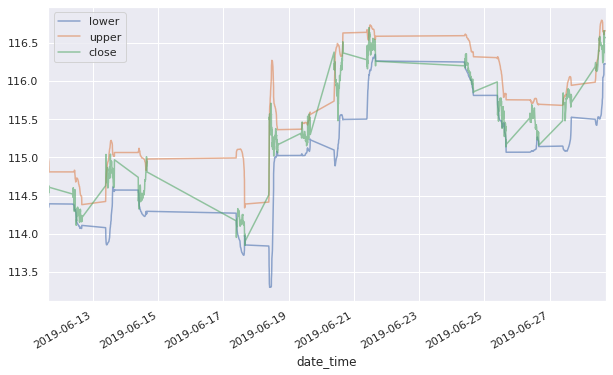

In [276]:
f,ax=plt.subplots(figsize=(10,6))
df.iloc[-1000:,:3].plot( alpha=0.6 ,ax=ax)

In [277]:
side = bbsignal
side.value_counts()

-1.0    15829
 1.0    15471
Name: side, dtype: int64

## 2. Generate labels (from a primary model)

Get time stamps of the events using CUSUM filter and point estimate of the volatility.

In [0]:
# form a tripple-barrier
pt_sl = [1,2]

target = util.get_daily_vol(close,lookback=100)

h = target.mean()*0.5
t_events = filters.cusum_filter(close, h) # using symmetric cusum filter, get t_events

vertical_barrier_times = labeling.add_vertical_barrier(t_events, close, num_days=1)

In [279]:
# events
min_ret = 0.0005

events = labeling.get_events(close, t_events, pt_sl, target, min_ret, num_threads=3, 
                             vertical_barrier_times = vertical_barrier_times ,side_prediction = side)

# label (bin) - binary classification from the primary model

bin = labeling.get_bins(events, close)

2020-01-31 16:13:45.797654 100.0% apply_pt_sl_on_t1 done after 0.7 minutes. Remaining 0.0 minutes.


In [280]:
bin.head()

ret      trgt  bin  side
2009-09-29 09:59:17  0.003091  0.002837    1  -1.0
2009-09-29 10:00:05  0.002906  0.002518    1  -1.0
2009-09-29 10:02:06       NaN  0.003789    0   NaN
2009-09-29 10:14:12       NaN  0.004484    0   NaN
2009-09-29 10:55:53       NaN  0.004242    0   NaN

In [0]:
bin.dropna(inplace=True)

In [282]:
bin.side.value_counts()

 1.0    1567
-1.0    1213
Name: side, dtype: int64

In [283]:
bin.bin.value_counts()

0    1535
1    1245
Name: bin, dtype: int64

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1535
           1       0.45      1.00      0.62      1245

    accuracy                           0.45      2780
   macro avg       0.22      0.50      0.31      2780
weighted avg       0.20      0.45      0.28      2780

Accuracy =  0.447841726618705

Confusion Matrix


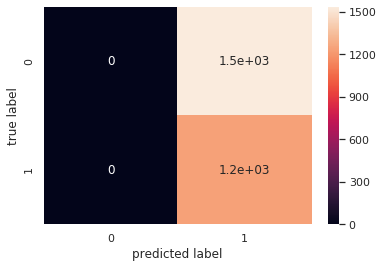

In [284]:
primary_forecast = pd.DataFrame(bin['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']

print(classification_report(actual, pred))

print("Accuracy = ", accuracy_score(actual,pred))
print('')
print("Confusion Matrix")
mat = confusion_matrix(actual, pred)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

In [285]:
bin

ret      trgt  bin  side
2009-09-29 09:59:17  0.003091  0.002837    1  -1.0
2009-09-29 10:00:05  0.002906  0.002518    1  -1.0
2009-09-30 09:46:02  0.006062  0.005880    1   1.0
2009-09-30 09:51:41  0.006671  0.006470    1   1.0
2009-09-30 09:57:13  0.009245  0.007836    1   1.0
...                       ...       ...  ...   ...
2019-06-18 09:48:55 -0.000237  0.005826    0  -1.0
2019-06-21 15:59:41  0.000000  0.002824    0   1.0
2019-06-25 09:38:22 -0.000260  0.002890    0   1.0
2019-06-25 15:52:11  0.003318  0.002574    1   1.0
2019-06-27 09:54:36  0.002993  0.002443    1  -1.0

[2780 rows x 4 columns]

## 3. Features



Features - Kara et al. (2011)


- Simple 10-day moving average
- Weighted 10-day moving average
- Momentum
- Stochastic K%
- Stochastic D%
- RSI (Relative Strength Index)
- MACD (moving average convergence divergence)
- Larry William’s R% 
- A/D (Accumulation/Distribution) Oscillator
- CCI (Commodity Channel Index)

### from TA

https://github.com/bukosabino/ta

In [286]:
bars = dollar_bars.iloc[:,1:6]
bars = bars.loc[bin.index,:]
bars.head()

open     high      low  close  volume
2009-09-29 09:59:17  51.80  51.9500  51.7500  51.92    3942
2009-09-29 10:00:05  51.88  51.8900  51.7400  51.76    3891
2009-09-30 09:46:02  51.25  51.2500  51.1400  51.14    4063
2009-09-30 09:51:41  51.17  51.2000  50.9427  50.97    4048
2009-09-30 09:57:13  51.02  51.0652  50.8400  50.84    4077

Volume
- Accumulation/Distribution Index (ADI)
-On-Balance Volume (OBV)
-Chaikin Money Flow (CMF)
-Force Index (FI)
-Ease of Movement (EoM, EMV)
-Volume-price Trend (VPT)
-Negative Volume Index (NVI)

Volatility
- Average True Range (ATR)
- Bollinger Bands (BB)
- Keltner Channel (KC)
- Donchian Channel (DC)

Trend
- Moving Average Convergence Divergence (MACD)
- Average Directional Movement Index (ADX)
- Vortex Indicator (VI)
- Trix (TRIX)
- Mass Index (MI)
- Commodity Channel Index (CCI)
- Detrended Price Oscillator (DPO)
- KST Oscillator (KST)
- Ichimoku Kinkō Hyō (Ichimoku)
- Parabolic Stop And Reverse (Parabolic SAR)

Momentum
- Money Flow Index (MFI)
- Relative Strength Index (RSI)
- True strength index (TSI)
- Ultimate Oscillator (UO)
- Stochastic Oscillator (SR)
- Williams %R (WR)
- Awesome Oscillator (AO)
- Kaufman's Adaptive Moving Average (KAMA)
- Rate of Change (ROC)

Others
- Daily Return (DR)
- Daily Log Return (DLR)
- Cumulative Return (CR)

In [0]:
ta_features = ta.add_all_ta_features(bars,'open','high','low','close','volume')

In [288]:
#look-ahead bias
ta_features = ta_features.shift(1)

ta_features.head()

open   high      low  ...  others_dr  others_dlr  others_cr
2009-09-29 09:59:17    NaN    NaN      NaN  ...        NaN         NaN        NaN
2009-09-29 10:00:05  51.80  51.95  51.7500  ... -36.903814         NaN   0.000000
2009-09-30 09:46:02  51.88  51.89  51.7400  ...  -0.308166   -0.308642  -0.308166
2009-09-30 09:51:41  51.25  51.25  51.1400  ...  -1.197836   -1.205068  -1.502311
2009-09-30 09:57:13  51.17  51.20  50.9427  ...  -0.332421   -0.332975  -1.829738

[5 rows x 72 columns]

In [289]:
ta_features.columns

Index(['open', 'high', 'low', 'close', 'volume', 'volume_adi', 'volume_obv',
       'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_nvi', 'volatility_atr', 'volatility_bbm', 'volatility_bbh',
       'volatility_bbl', 'volatility_bbw', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dchi', 'volatility_dcli', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_ema_fast',
       'trend_ema_slow', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_a',
       'trend_ichimoku_b', 'trend_visual_ichimoku_a',
       'trend_visual_ichimoku_b', 'trend_aroon_up', 'trend_aroon_down',
   

In [0]:
ta_features_3 = ta_features.loc[:, ['volume_adi', 'volatility_atr', 'trend_macd',
                    'trend_cci', 'momentum_rsi', 'momentum_stoch', 'momentum_kama']]

In [291]:
ta_features_3 = ta_features_3.dropna(axis=1,how='any',thresh=len(ta_features)-20)
ta_features_3 = ta_features_3.dropna()
ta_features_3

volume_adi  ...  momentum_kama
2009-10-05 09:59:09 -15021.874611  ...      49.240000
2009-10-05 10:08:24 -11839.965722  ...      49.341833
2009-10-06 09:34:36 -15921.965722  ...      49.409225
2009-10-06 09:43:53 -12975.215722  ...      49.420623
2009-10-06 10:47:27  -9219.987840  ...      49.435317
...                           ...  ...            ...
2019-06-18 09:48:55  47138.123663  ...     114.127262
2019-06-21 15:59:41  49120.123663  ...     114.344439
2019-06-25 09:38:22  47588.679218  ...     114.708258
2019-06-25 15:52:11  45635.679218  ...     114.800905
2019-06-27 09:54:36  43347.679218  ...     114.816931

[2770 rows x 6 columns]

### Other features

from hudson-thames

In [0]:
raw_data = pd.DataFrame(bars.close)

log_ret = np.log(raw_data['close']).diff()

raw_data['sma10'] = raw_data['close'].rolling(window = 10).mean()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)

'''# Volatility
raw_data['volatility_50'] = log_ret.rolling(window=50, min_periods=50, center=False).std()
raw_data['volatility_31'] = log_ret.rolling(window=31, min_periods=31, center=False).std()
raw_data['volatility_15'] = log_ret.rolling(window=15, min_periods=15, center=False).std()'''

# Serial Correlation
window_autocorr = 50

raw_data['autocorr_1'] = log_ret.rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = log_ret.rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = log_ret.rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)

# Remove look ahead bias
raw_data = raw_data.shift(1)

In [0]:
raw_X = raw_data.join(ta_features_3)
raw_X = raw_X.iloc[:,1:]
raw_X.dropna(inplace=True)

In [294]:
raw_X

sma10      mom1  ...  momentum_stoch  momentum_kama
2009-11-09 11:21:44   49.97759  0.003577  ...      100.000000      50.102822
2009-11-11 09:57:56   50.21059  0.002909  ...       98.760933      50.294694
2009-11-11 10:13:22   50.54699  0.017279  ...      100.000000      50.694718
2009-11-11 10:43:41   50.92147  0.002675  ...      100.000000      51.134453
2009-11-16 09:42:32   51.21947 -0.001986  ...       97.201453      51.396334
...                        ...       ...  ...             ...            ...
2019-06-18 09:48:55  114.10260  0.001657  ...       94.848485     114.127262
2019-06-21 15:59:41  114.35760  0.004527  ...      100.000000     114.344439
2019-06-25 09:38:22  114.66760  0.007020  ...       98.204345     114.708258
2019-06-25 15:52:11  114.90360 -0.005336  ...       84.288023     114.800905
2019-06-27 09:54:36  115.03907 -0.003824  ...       69.051491     114.816931

[2729 rows x 13 columns]

### PCA

In [295]:
# Feature decomposition PCA

n=5
pca = PCA(n)
pca.fit(raw_X)
pcaX = pca.transform(raw_X)

X = pd.DataFrame(index=raw_X.index)
for i in range(n):
  a = pd.Series(data=pcaX[:,i],index=raw_X.index,name=i)
  X = X.join(a)
'''

# No PCA
X = raw_X.copy()'''

'\n\n# No PCA\nX = raw_X.copy()'

### Including side from first model

In [0]:
X['side'] = side

### Fracdiff

In [0]:
#fd = features.fracdiff.frac_diff(bars.close.to_frame(),0.2)

In [0]:
#X['fd'] = fd

### X

In [0]:
X.dropna(inplace=True)

In [300]:
X.head()

0           1  ...          4  side
2009-11-09 11:21:44 -468845.750277 -253.451242  ...  12.582266  -1.0
2009-11-11 09:57:56 -467158.556501 -231.244533  ...   9.627995  -1.0
2009-11-11 10:13:22 -463273.555552 -255.587972  ...   6.286077  -1.0
2009-11-11 10:43:41 -459297.557606 -202.268714  ...   0.930909  -1.0
2009-11-16 09:42:32 -463248.559181 -161.643923  ...  -1.445855  -1.0

[5 rows x 6 columns]

In [301]:
len(X)

2729

## 4. Fit a second ML model

In [0]:
tmp_data = X.copy()
tmp_data = tmp_data.join(bin.bin)
tmp_data.dropna(inplace=True)

X = tmp_data.iloc[:,:-1]
y = tmp_data[['bin']]

In [0]:
t1 = events['t1'].loc[X.index]
idx = events.loc[X.index].index

In [304]:
X

0           1  ...          4  side
2009-11-09 11:21:44 -468845.750277 -253.451242  ...  12.582266  -1.0
2009-11-11 09:57:56 -467158.556501 -231.244533  ...   9.627995  -1.0
2009-11-11 10:13:22 -463273.555552 -255.587972  ...   6.286077  -1.0
2009-11-11 10:43:41 -459297.557606 -202.268714  ...   0.930909  -1.0
2009-11-16 09:42:32 -463248.559181 -161.643923  ...  -1.445855  -1.0
...                            ...         ...  ...        ...   ...
2019-06-18 09:48:55 -430868.692661 -111.933493  ...   1.368387  -1.0
2019-06-21 15:59:41 -428886.692251 -122.439214  ...  -0.122078   1.0
2019-06-25 09:38:22 -430418.135934 -142.113104  ...  -2.070061   1.0
2019-06-25 15:52:11 -432371.137307 -106.929182  ...  -0.525529   1.0
2019-06-27 09:54:36 -434659.138460  -77.319612  ...  -0.147102  -1.0

[2729 rows x 6 columns]

In [0]:
#skf = cross_validation.PurgedKFold(n_splits=5,samples_info_sets= t1, pct_embargo = 0.01)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

### 1st - Random Forest

In [307]:
avgU = sampling.get_av_uniqueness_from_triple_barrier(t1.to_frame(), bars.close, 3).mean()
max_samples = avgU[0]
max_samples

2020-01-31 16:14:22.909369 100.0% num_concurrent_events done after 0.03 minutes. Remaining 0.0 minutes.
2020-01-31 16:14:24.222636 100.0% _get_average_uniqueness done after 0.02 minutes. Remaining 0.0 minutes.


0.6312398471121136

In [308]:
clf0 = RandomForestClassifier(n_estimators=1,criterion='entropy',bootstrap = False, class_weight='balanced_subsample')
clf1 = BaggingClassifier(base_estimator=clf0, max_samples=max_samples, max_features=1, n_estimators=1000)
clf1.fit(X_train, y_train.values.ravel())

#this is the method in the book

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=False,
                                                        ccp_alpha=0.0,
                                                        class_weight='balanced_subsample',
                                                        criterion='entropy',
                                                        max_depth=None,
                                                        max_features='auto',
                                                        max_leaf_nodes=None,
                                                        max_samples=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_frac

In [309]:
'''parameters = {'max_depth':[2, 3, 5, 7],
              'n_estimators':[100, 512, 1000]}
#hyper-parameter tuning

rf = RandomForestClassifier(criterion='entropy',max_samples=max_samples, class_weight='balanced_subsample')
clf = GridSearchCV(rf, parameters, cv=3, n_jobs=3)
clf.fit(X_train, y_train.values.ravel())'''

"parameters = {'max_depth':[2, 3, 5, 7],\n              'n_estimators':[100, 512, 1000]}\n#hyper-parameter tuning\n\nrf = RandomForestClassifier(criterion='entropy',max_samples=max_samples, class_weight='balanced_subsample')\nclf = GridSearchCV(rf, parameters, cv=3, n_jobs=3)\nclf.fit(X_train, y_train.values.ravel())"

In [0]:
#clf.best_estimator_

#### Train metrics - RF

In [0]:
y_pred_prob_0 = clf1.predict_proba(X_train)[:, 1]
y_pred_0 = clf1.predict(X_train)

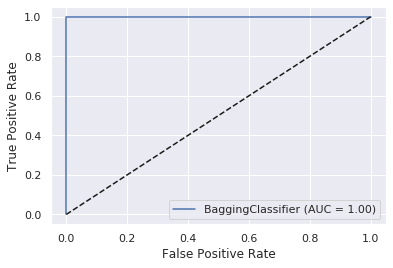

In [312]:
rf_disp = plot_roc_curve(clf1, X_train, y_train)
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       957
           1       1.00      1.00      1.00       680

    accuracy                           1.00      1637
   macro avg       1.00      1.00      1.00      1637
weighted avg       1.00      1.00      1.00      1637

Accuracy =  1.0

Confusion Matrix


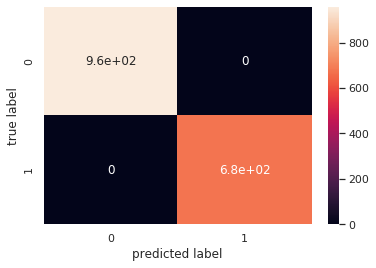

In [313]:
print(classification_report(y_train, y_pred_0))

print("Accuracy = ", accuracy_score(y_train, y_pred_0))
print('')
print("Confusion Matrix")
mat = confusion_matrix(y_train, y_pred_0)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

#### Test metrics -RF

In [0]:
y_pred = clf1.predict(X_test)
y_pred_prob = clf1.predict_proba(X_test)[:, 1]

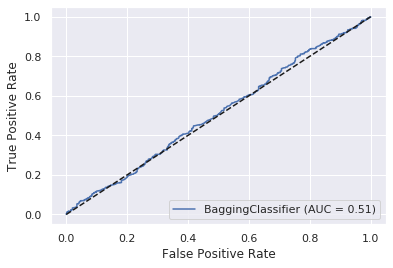

In [315]:
rf_disp = plot_roc_curve(clf1, X_test, y_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.show();

              precision    recall  f1-score   support

           0       0.51      0.51      0.51       546
           1       0.51      0.50      0.50       546

    accuracy                           0.51      1092
   macro avg       0.51      0.51      0.51      1092
weighted avg       0.51      0.51      0.51      1092

Accuracy =  0.5064102564102564

Confusion Matrix


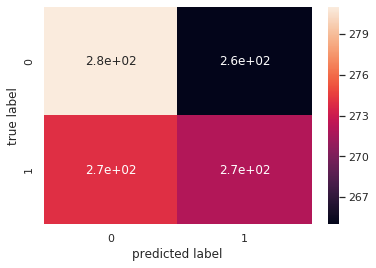

In [316]:
print(classification_report(y_test, y_pred))

print("Accuracy = ", accuracy_score(y_test, y_pred))
print('')
print("Confusion Matrix")
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

### 2nd - SVC

In [317]:
parameters = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

svc = SVC(kernel='rbf', probability=True)

clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [318]:
clf.best_estimator_

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

#### Train metrics - SVC

In [0]:
y_pred_prob_0_svc = clf.predict_proba(X_train)[:, 1]
y_pred_0_svc = clf.predict(X_train)

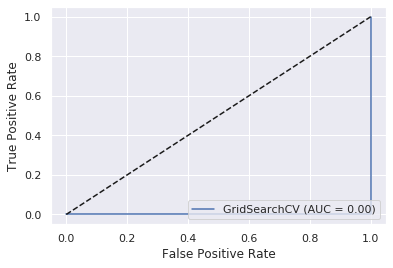

In [320]:
svc_disp = plot_roc_curve(clf, X_train, y_train)
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

              precision    recall  f1-score   support

           0       0.58      1.00      0.74       957
           1       0.00      0.00      0.00       680

    accuracy                           0.58      1637
   macro avg       0.29      0.50      0.37      1637
weighted avg       0.34      0.58      0.43      1637

Accuracy =  0.5846059865607819

Confusion Matrix


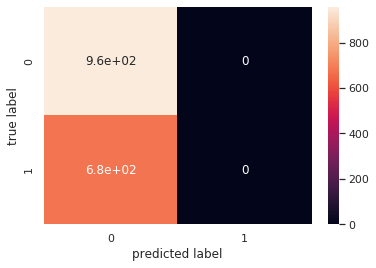

In [321]:
print(classification_report(y_train, y_pred_0_svc))

print("Accuracy = ", accuracy_score(y_train, y_pred_0_svc))
print('')
print("Confusion Matrix")
mat = confusion_matrix(y_train, y_pred_0_svc)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

#### Test Metrics - SVC

In [0]:
y_pred_svc = clf.predict(X_test)
y_pred_prob_svc = clf.predict_proba(X_test)[:, 1]

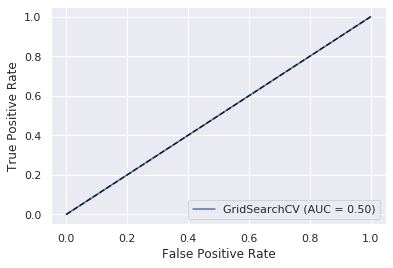

In [323]:
svc_disp = plot_roc_curve(clf, X_test, y_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       546
           1       0.00      0.00      0.00       546

    accuracy                           0.50      1092
   macro avg       0.25      0.50      0.33      1092
weighted avg       0.25      0.50      0.33      1092

Accuracy =  0.5

Confusion Matrix


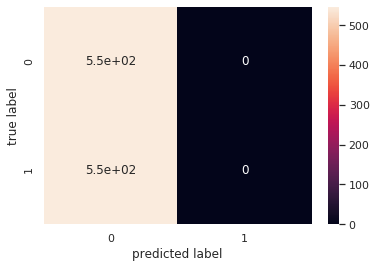

In [324]:
print(classification_report(y_test, y_pred_svc))

print("Accuracy = ", accuracy_score(y_test, y_pred_svc))
print('')
print("Confusion Matrix")
mat = confusion_matrix(y_test, y_pred_svc)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

### 3rd - Boosting

In [325]:
parameters = {
    "loss":["deviance"],
    "learning_rate": [0.05, 0.1, 0.15, 0.2],
    "subsample":[0.5, 0.8, 1.0]
    }

gbc = GradientBoostingClassifier()

clf2 = GridSearchCV(gbc, parameters)
clf2.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
      

In [326]:
clf2.best_estimator_

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

#### Train metrics - GBC

In [0]:
y_pred_prob_0_gbc = clf2.predict_proba(X_train)[:, 1]
y_pred_0_gbc = clf2.predict(X_train)

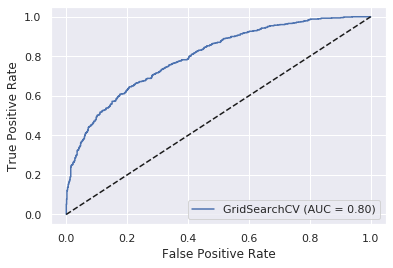

In [328]:
svc_disp = plot_roc_curve(clf2, X_train, y_train)
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

              precision    recall  f1-score   support

           0       0.70      0.91      0.80       957
           1       0.79      0.46      0.58       680

    accuracy                           0.73      1637
   macro avg       0.75      0.69      0.69      1637
weighted avg       0.74      0.73      0.71      1637

Accuracy =  0.7251069028711057

Confusion Matrix


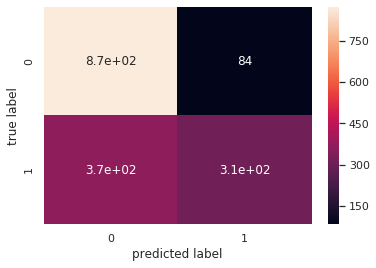

In [329]:
print(classification_report(y_train, y_pred_0_gbc))

print("Accuracy = ", accuracy_score(y_train, y_pred_0_gbc))
print('')
print("Confusion Matrix")
mat = confusion_matrix(y_train, y_pred_0_gbc)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

#### Test metrics - GBC

In [0]:
y_pred_gbc = clf2.predict(X_test)
y_pred_prob_gbc = clf2.predict_proba(X_test)[:, 1]

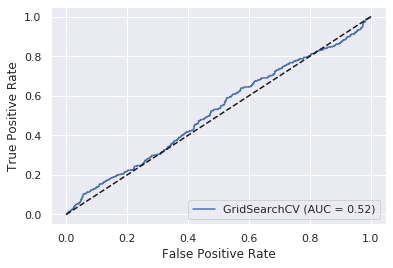

In [331]:
gbc_disp = plot_roc_curve(clf2, X_test, y_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

              precision    recall  f1-score   support

           0       0.51      0.60      0.55       546
           1       0.51      0.42      0.46       546

    accuracy                           0.51      1092
   macro avg       0.51      0.51      0.50      1092
weighted avg       0.51      0.51      0.50      1092

Accuracy =  0.5082417582417582

Confusion Matrix


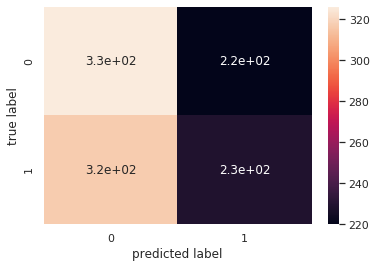

In [332]:
print(classification_report(y_test, y_pred_gbc))

print("Accuracy = ", accuracy_score(y_test, y_pred_gbc))
print('')
print("Confusion Matrix")
mat = confusion_matrix(y_test, y_pred_gbc)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

## 5. Bet Sizing

When num_classes = 2,



$$ z=\frac{p[x=1]−\frac{1}{2}}{\sqrt{p[x=1](1−p[x=1])}} $$

$$ m=2Z[z]−1 $$

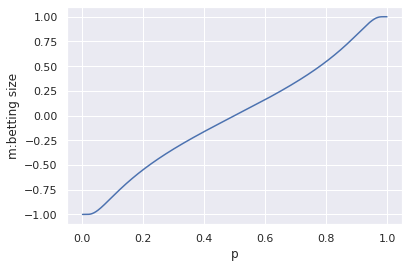

In [333]:
import scipy.stats as ss
p = np.linspace(0.001,1,1000,endpoint=False)
z = (p-0.5)/(np.sqrt(p*(1-p)))
Z_z = ss.norm.cdf(z)
m = (2 * Z_z -1) # np.sign(x)=1 always? increasing function
plt.plot(p,m)
plt.xlabel('p');
plt.ylabel('m:betting size');

In [0]:
from mlfinlab import bet_sizing as bs

In [0]:
p_rf = y_pred_prob # from RF (secondary model)
#p = y_pred_prob_svc # from SVM
p_gbc = y_pred_prob_gbc # from Gradient Boosting

In [427]:
new_data = y_test.copy()
new_data['p_gbc'] = p_gbc
new_data['p_rf'] = p_rf
new_data['pred'] = y_pred
new_data

bin     p_gbc      p_rf  pred
2015-12-09 10:30:59    1  0.392509  0.479518     0
2015-12-10 10:39:54    1  0.402064  0.436518     0
2015-12-11 12:24:33    0  0.497739  0.425600     0
2015-12-11 15:23:28    0  0.432295  0.518600     1
2015-12-14 10:12:29    1  0.546243  0.467600     0
...                  ...       ...       ...   ...
2019-06-18 09:48:55    0  0.514778  0.558518     1
2019-06-21 15:59:41    0  0.619665  0.531600     1
2019-06-25 09:38:22    0  0.583074  0.442600     0
2019-06-25 15:52:11    1  0.494362  0.448600     0
2019-06-27 09:54:36    1  0.490841  0.666518     1

[1092 rows x 4 columns]

In [0]:
# test에 맞추자
new_events = events.loc[new_data.index]
bs_df = pd.concat([new_events, new_data],axis=1)

In [429]:
bs_df

t1      trgt  ...      p_rf  pred
2015-12-09 10:30:59 2015-12-09 11:46:52  0.007626  ...  0.479518     0
2015-12-10 10:39:54 2015-12-10 12:19:43  0.003764  ...  0.436518     0
2015-12-11 12:24:33 2015-12-14 09:30:00  0.008913  ...  0.425600     0
2015-12-11 15:23:28 2015-12-14 09:30:00  0.007119  ...  0.518600     1
2015-12-14 10:12:29 2015-12-15 09:30:00  0.010737  ...  0.467600     0
...                                 ...       ...  ...       ...   ...
2019-06-18 09:48:55 2019-06-19 09:54:13  0.005826  ...  0.558518     1
2019-06-21 15:59:41 2019-06-24 09:29:59  0.002824  ...  0.531600     1
2019-06-25 09:38:22 2019-06-26 09:46:40  0.002890  ...  0.442600     0
2019-06-25 15:52:11 2019-06-26 09:30:00  0.002574  ...  0.448600     0
2019-06-27 09:54:36 2019-06-27 11:19:07  0.002443  ...  0.666518     1

[1092 rows x 9 columns]

In [432]:
m_prob_rf = bs.bet_size_probability(events = bs_df[['t1']], prob = bs_df.p_rf, num_classes=2, num_threads=3)
m_prob_rf

2015-12-09 10:30:59   -0.032703
2015-12-10 10:39:54   -0.101851
2015-12-11 12:24:33   -0.119610
2015-12-11 15:23:28    0.029696
2015-12-14 10:12:29   -0.051775
                         ...   
2019-06-18 09:48:55    0.093810
2019-06-21 15:59:41    0.050494
2019-06-25 09:38:22   -0.092001
2019-06-25 15:52:11   -0.082312
2019-06-27 09:54:36    0.276061
Name: signal, Length: 1092, dtype: float64

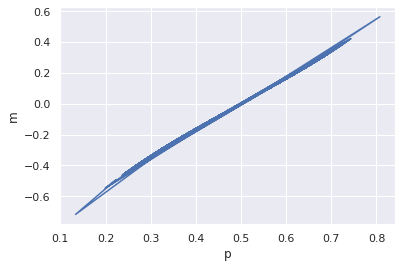

In [434]:
plt.plot(bs_df.p_rf, m_prob_rf)
plt.xlabel('p');
plt.ylabel('m');

In [435]:
m_prob_gbc = bs.bet_size_probability(events = bs_df[['t1']], prob = bs_df.p_gbc, num_classes=2, num_threads=3)
m_prob_gbc

2015-12-09 10:30:59   -0.174230
2015-12-10 10:39:54   -0.158317
2015-12-11 12:24:33   -0.003608
2015-12-11 15:23:28   -0.108707
2015-12-14 10:12:29    0.074004
                         ...   
2019-06-18 09:48:55    0.023589
2019-06-21 15:59:41    0.194700
2019-06-25 09:38:22    0.133803
2019-06-25 15:52:11   -0.008998
2019-06-27 09:54:36   -0.014617
Name: signal, Length: 1092, dtype: float64

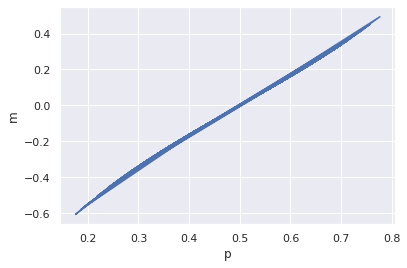

In [436]:
plt.plot(bs_df.p_gbc, m_prob_gbc)
plt.xlabel('p');
plt.ylabel('m');

average

In [444]:
m_prob_avg_rf = bs.bet_size_probability(events = bs_df[['t1']], prob = bs_df.p_rf, num_classes=2, num_threads=3, average_active=True)
m_prob_avg_rf = m_prob_avg_rf.loc[bs_df.index]
m_prob_avg_rf

2020-01-31 16:29:53.235865 100.0% mp_avg_active_signals done after 0.07 minutes. Remaining 0.0 minutes.


2015-12-09 10:30:59   -0.032703
2015-12-10 10:39:54   -0.101851
2015-12-11 12:24:33   -0.119610
2015-12-11 15:23:28   -0.044957
2015-12-14 10:12:29   -0.051775
                         ...   
2019-06-18 09:48:55    0.147519
2019-06-21 15:59:41    0.050494
2019-06-25 09:38:22   -0.092001
2019-06-25 15:52:11   -0.087157
2019-06-27 09:54:36    0.276061
Length: 1092, dtype: float64

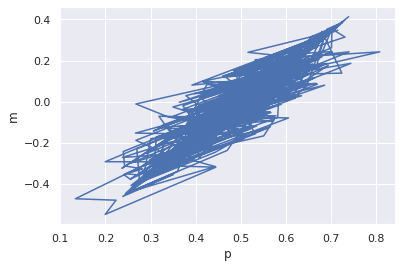

In [445]:
plt.plot(bs_df.p_rf, m_prob_avg_rf)
plt.xlabel('p');
plt.ylabel('m');

In [446]:
m_prob_avg_gbc = bs.bet_size_probability(events = bs_df[['t1']], prob = bs_df.p_gbc, num_classes=2, num_threads=3, average_active=True)
m_prob_avg_gbc = m_prob_avg_gbc.loc[bs_df.index]
m_prob_avg_gbc

2020-01-31 16:29:58.324825 100.0% mp_avg_active_signals done after 0.08 minutes. Remaining 0.0 minutes.


2015-12-09 10:30:59   -0.174230
2015-12-10 10:39:54   -0.158317
2015-12-11 12:24:33   -0.003608
2015-12-11 15:23:28   -0.056157
2015-12-14 10:12:29    0.074004
                         ...   
2019-06-18 09:48:55    0.015040
2019-06-21 15:59:41    0.194700
2019-06-25 09:38:22    0.133803
2019-06-25 15:52:11    0.062402
2019-06-27 09:54:36   -0.014617
Length: 1092, dtype: float64

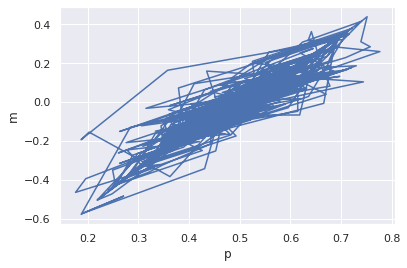

In [447]:
plt.plot(bs_df.p_gbc, m_prob_avg_gbc)
plt.xlabel('p');
plt.ylabel('m');

discrete

In [448]:
m_prob_discrete_rf = bs.bet_size_probability(events = bs_df[['t1']], prob = bs_df.p_rf, num_classes=2, num_threads=3, average_active=True, step_size=0.01)
m_prob_discrete_rf = m_prob_discrete_rf.loc[bs_df.index]
m_prob_discrete_rf

2020-01-31 16:30:25.073783 100.0% mp_avg_active_signals done after 0.08 minutes. Remaining 0.0 minutes.


2015-12-09 10:30:59   -0.03
2015-12-10 10:39:54   -0.10
2015-12-11 12:24:33   -0.12
2015-12-11 15:23:28   -0.04
2015-12-14 10:12:29   -0.05
                       ... 
2019-06-18 09:48:55    0.15
2019-06-21 15:59:41    0.05
2019-06-25 09:38:22   -0.09
2019-06-25 15:52:11   -0.09
2019-06-27 09:54:36    0.28
Length: 1092, dtype: float64

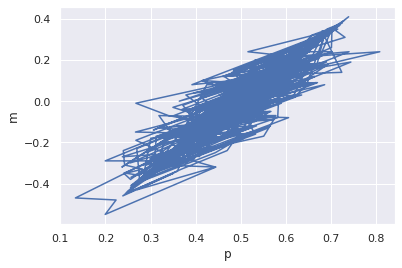

In [450]:
plt.plot(bs_df.p_rf, m_prob_discrete_rf)
plt.xlabel('p');
plt.ylabel('m');

In [451]:
m_prob_discrete_gbc = bs.bet_size_probability(events = bs_df[['t1']], prob = bs_df.p_gbc, num_classes=2, num_threads=3, average_active=True, step_size=0.01)
m_prob_discrete_gbc = m_prob_discrete_gbc.loc[bs_df.index]
m_prob_discrete_gbc

2020-01-31 16:30:59.216787 100.0% mp_avg_active_signals done after 0.07 minutes. Remaining 0.0 minutes.


2015-12-09 10:30:59   -0.17
2015-12-10 10:39:54   -0.16
2015-12-11 12:24:33   -0.00
2015-12-11 15:23:28   -0.06
2015-12-14 10:12:29    0.07
                       ... 
2019-06-18 09:48:55    0.02
2019-06-21 15:59:41    0.19
2019-06-25 09:38:22    0.13
2019-06-25 15:52:11    0.06
2019-06-27 09:54:36   -0.01
Length: 1092, dtype: float64

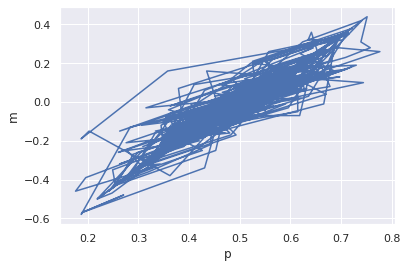

In [452]:
plt.plot(bs_df.p_gbc, m_prob_discrete_gbc)
plt.xlabel('p');
plt.ylabel('m');

# 2. Bet Sizing (reserve)

$c_t = c_{t,l} - c_{t,s} $ 

where $c_{t,l}$ is the number of concurrent long bets at
time $t$, and $c_{t,s}$ is the number of concurrent short bets at time $t$

$$m_t = \begin{cases}
  \frac{F[c_t]-F[0]}{1-F[0]} & \text{if}\ c_t \ge 0 \\
  \frac{F[c_t]-F[0]}{F[0]} & \text{if}\ c_t < 0
\end{cases}$$

where $F[x]$ is CDF of the fitted mixture of two Gaussians for a value x.

EF3M Algorithm



https://github.com/hudson-and-thames/research/blob/master/Chapter10/ef3m_testing.ipynb

In [348]:
m_reserve = bs.bet_sizing.bet_size_reserve(events_t1=bs_df['t1'], sides=bs_df.side, return_parameters=True, fit_runs=25)

|#########################| Completed 25 of 25 fitting rounds.

In [349]:
m_reserve[0]

t1  side  ...  c_t  bet_size
2015-12-09 10:30:59 2015-12-09 11:46:52  -1.0  ...   -1 -0.426840
2015-12-10 10:39:54 2015-12-10 12:19:43  -1.0  ...   -1 -0.426840
2015-12-11 12:24:33 2015-12-14 09:30:00   1.0  ...    1  0.400521
2015-12-11 15:23:28 2015-12-14 09:30:00   1.0  ...    2  0.762146
2015-12-14 10:12:29 2015-12-15 09:30:00   1.0  ...    1  0.400521
...                                 ...   ...  ...  ...       ...
2019-06-18 09:48:55 2019-06-19 09:54:13  -1.0  ...   -2 -0.818360
2019-06-21 15:59:41 2019-06-24 09:29:59   1.0  ...    1  0.400521
2019-06-25 09:38:22 2019-06-26 09:46:40   1.0  ...    1  0.400521
2019-06-25 15:52:11 2019-06-26 09:30:00   1.0  ...    2  0.762146
2019-06-27 09:54:36 2019-06-27 11:19:07  -1.0  ...   -1 -0.426840

[1092 rows x 6 columns]

In [0]:
BetSizeReserve = m_reserve[0].bet_size

In [351]:
m_reserve[1]
#parameter for two Gaussian mixture

{'mu_1': -1.50543,
 'mu_2': 0.88642,
 'p_1': 0.28101,
 'sigma_1': 0.77561,
 'sigma_2': 1.23681}

# 3. Bet sizing (budget)

$$ m_t = c_{t,l} \frac{1}{max_i[c_{i,l}]}-c_{t,s} \frac{1}{max_i[c_{i,s}]} $$

In [352]:
m_budget = bs.bet_sizing.bet_size_budget(bs_df.t1, bs_df.side)
m_budget

t1  side  ...  active_short  bet_size
2015-12-09 10:30:59 2015-12-09 11:46:52  -1.0  ...             1     -0.25
2015-12-10 10:39:54 2015-12-10 12:19:43  -1.0  ...             1     -0.25
2015-12-11 12:24:33 2015-12-14 09:30:00   1.0  ...             0      0.20
2015-12-11 15:23:28 2015-12-14 09:30:00   1.0  ...             0      0.40
2015-12-14 10:12:29 2015-12-15 09:30:00   1.0  ...             0      0.20
...                                 ...   ...  ...           ...       ...
2019-06-18 09:48:55 2019-06-19 09:54:13  -1.0  ...             2     -0.50
2019-06-21 15:59:41 2019-06-24 09:29:59   1.0  ...             0      0.20
2019-06-25 09:38:22 2019-06-26 09:46:40   1.0  ...             0      0.20
2019-06-25 15:52:11 2019-06-26 09:30:00   1.0  ...             0      0.40
2019-06-27 09:54:36 2019-06-27 11:19:07  -1.0  ...             1     -0.25

[1092 rows x 5 columns]

In [0]:
BetSizeBudget = m_budget.bet_size

# 4. Overview

In [453]:
bet_size_0 = pd.DataFrame({'BetSizeProbRF':m_prob_rf,'BetSizeProbAvgRF':m_prob_avg_rf,'BetSizeProbDiscreteRF':m_prob_discrete_rf,
                           'BetSizeProbGB':m_prob_gbc,'BetSizeProbAvgGB':m_prob_avg_gbc,'BetSizeProbDiscreteGB':m_prob_discrete_gbc})
bet_size_1 = bet_size_0.join(BetSizeReserve)
bet_size = bet_size_1.join(BetSizeBudget,rsuffix='2')
bet_size = bet_size.rename(columns={'bet_size':'BetSizeReserve', 'bet_size2':'BetSizeBudget'})
bet_size['NoSize'] = bs_df.side*bs_df.pred
bet_size

BetSizeProbRF  BetSizeProbAvgRF  ...  BetSizeBudget  NoSize
2015-12-09 10:30:59      -0.032703         -0.032703  ...          -0.25    -0.0
2015-12-10 10:39:54      -0.101851         -0.101851  ...          -0.25    -0.0
2015-12-11 12:24:33      -0.119610         -0.119610  ...           0.20     0.0
2015-12-11 15:23:28       0.029696         -0.044957  ...           0.40     1.0
2015-12-14 10:12:29      -0.051775         -0.051775  ...           0.20     0.0
...                            ...               ...  ...            ...     ...
2019-06-18 09:48:55       0.093810          0.147519  ...          -0.50    -1.0
2019-06-21 15:59:41       0.050494          0.050494  ...           0.20     1.0
2019-06-25 09:38:22      -0.092001         -0.092001  ...           0.20     0.0
2019-06-25 15:52:11      -0.082312         -0.087157  ...           0.40     0.0
2019-06-27 09:54:36       0.276061          0.276061  ...          -0.25    -1.0

[1092 rows x 9 columns]

In [0]:
bet_size.dropna(inplace=True)

Plot

Text(0.5, 1.0, 'Bet Size 100 points')

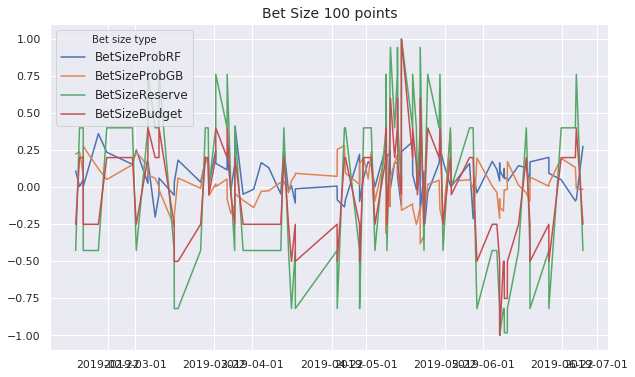

In [456]:
fig, ax = plt.subplots(figsize=(10,6))
bet_size_3 = bet_size.drop(['BetSizeProbAvgRF','BetSizeProbDiscreteRF','BetSizeProbAvgGB','BetSizeProbDiscreteGB','NoSize'],axis=1)
ax.plot(bet_size_3[-100:])

ax.legend(labels=bet_size_3.columns,loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax.set_title("Bet Size 100 points", fontsize=14)

Text(0.5, 1.0, 'Bet Size Prob 100 points')

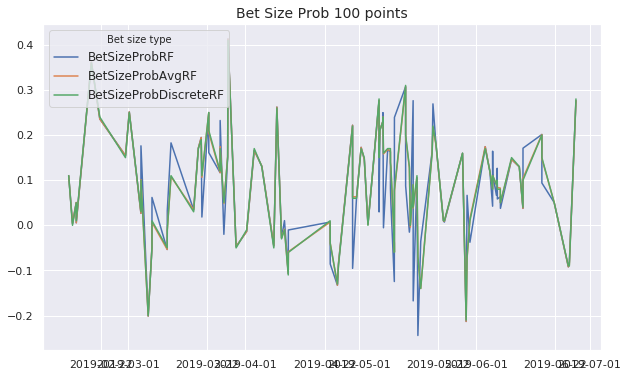

In [457]:
fig, ax = plt.subplots(figsize=(10,6))
bet_size_4 = bet_size.iloc[:,:3]
ax.plot(bet_size_4[-100:])

ax.legend(labels=bet_size_4.columns,loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax.set_title("Bet Size Prob 100 points", fontsize=14)

Text(0.5, 1.0, 'Bet Size Prob 100 points')

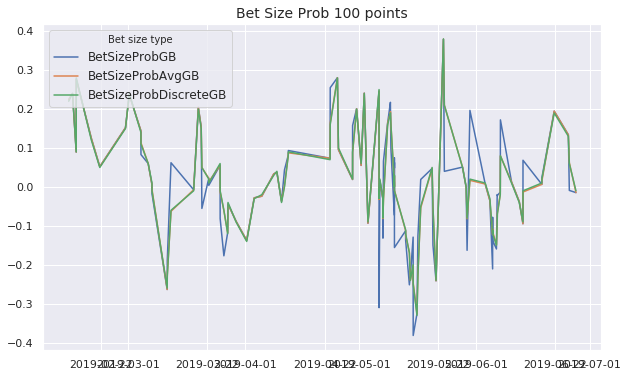

In [458]:
fig, ax = plt.subplots(figsize=(10,6))
bet_size_4 = bet_size.iloc[:,3:6]
ax.plot(bet_size_4[-100:])

ax.legend(labels=bet_size_4.columns,loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax.set_title("Bet Size Prob 100 points", fontsize=14)

Text(0.5, 1.0, 'Bet Size Distribution')

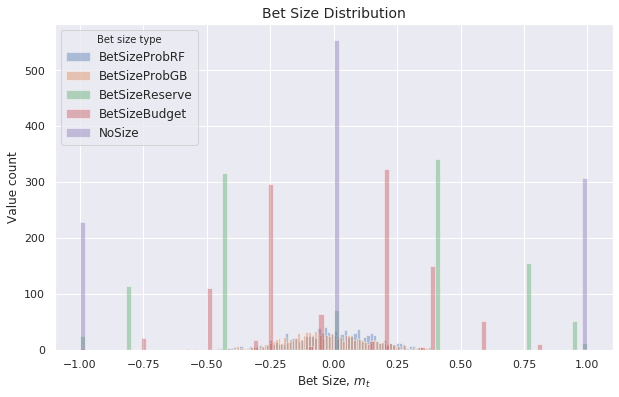

In [459]:
fig, ax = plt.subplots(figsize=(10,6))
for c in ['BetSizeProbRF','BetSizeProbGB','BetSizeReserve', 'BetSizeBudget','NoSize']:
    ax.hist(bet_size[c],  label=c, alpha=0.4, bins=100)
ax.legend(loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax.set_xlabel("Bet Size, $m_t$", fontsize=12)
ax.set_ylabel("Value count", fontsize=12)
ax.set_title("Bet Size Distribution", fontsize=14)

Text(0.5, 1.0, 'Bet Size Distribution')

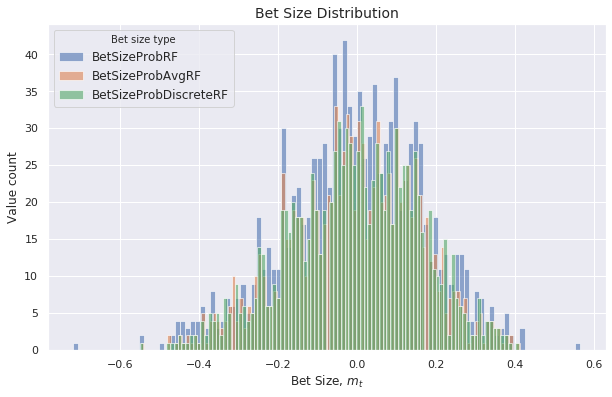

In [461]:
fig, ax = plt.subplots(figsize=(10,6))
for c in ['BetSizeProbRF','BetSizeProbAvgRF', 'BetSizeProbDiscreteRF']:
    ax.hist(bet_size[c],  label=c, alpha=0.6, bins=100)
ax.legend(loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax.set_xlabel("Bet Size, $m_t$", fontsize=12)
ax.set_ylabel("Value count", fontsize=12)
ax.set_title("Bet Size Distribution", fontsize=14)

## returns

In [0]:
data_profit = bet_size.copy()
data_profit['NoSize'] = (bs_df.side*bs_df.pred).loc[bet_size.index] 
data_profit['ret'] = bin.ret.loc[bet_size.index]

In [463]:
data_profit

BetSizeProbRF  BetSizeProbAvgRF  ...  NoSize       ret
2015-12-09 10:30:59      -0.032703         -0.032703  ...    -0.0  0.009417
2015-12-10 10:39:54      -0.101851         -0.101851  ...    -0.0  0.004049
2015-12-11 12:24:33      -0.119610         -0.119610  ...     0.0 -0.001024
2015-12-11 15:23:28       0.029696         -0.044957  ...     1.0  0.001721
2015-12-14 10:12:29      -0.051775         -0.051775  ...     0.0  0.017954
...                            ...               ...  ...     ...       ...
2019-06-18 09:48:55       0.093810          0.147519  ...    -1.0 -0.000237
2019-06-21 15:59:41       0.050494          0.050494  ...     1.0  0.000000
2019-06-25 09:38:22      -0.092001         -0.092001  ...     0.0 -0.000260
2019-06-25 15:52:11      -0.082312         -0.087157  ...     0.0  0.003318
2019-06-27 09:54:36       0.276061          0.276061  ...    -1.0  0.002993

[1092 rows x 10 columns]

In [0]:
mprob = data_profit.BetSizeProbRF
mproba = data_profit.BetSizeProbAvgRF
mprobd = data_profit.BetSizeProbDiscreteRF
mprob1 = data_profit.BetSizeProbGB
mproba1 = data_profit.BetSizeProbAvgGB
mprobd1 = data_profit.BetSizeProbDiscreteGB
mres = data_profit.BetSizeReserve
mbudg = data_profit.BetSizeBudget
mret = data_profit.ret
mnosize = data_profit.NoSize

In [0]:
bet_profit = pd.DataFrame()
bet_profit['ProbRF'] = -mprob*mret
bet_profit['ProbAvgRF'] = -mproba*mret
bet_profit['ProbDiscreteRF'] = -mprobd*mret
bet_profit['ProbGB'] = -mprob1*mret
bet_profit['ProbAvgGB'] = -mproba1*mret
bet_profit['ProbDiscreteGB'] = -mprobd1*mret
bet_profit['Reserve'] = -mres*mret
bet_profit['Budget'] = -mbudg*mret
bet_profit['NoSize'] = -mnosize*mret

In [466]:
bet_profit.head()

ProbRF  ProbAvgRF  ...    Budget    NoSize
2015-12-09 10:30:59  0.000308   0.000308  ...  0.002354  0.000000
2015-12-10 10:39:54  0.000412   0.000412  ...  0.001012  0.000000
2015-12-11 12:24:33 -0.000122  -0.000122  ...  0.000205  0.000000
2015-12-11 15:23:28 -0.000051   0.000077  ... -0.000688 -0.001721
2015-12-14 10:12:29  0.000930   0.000930  ... -0.003591 -0.000000

[5 rows x 9 columns]

수익률

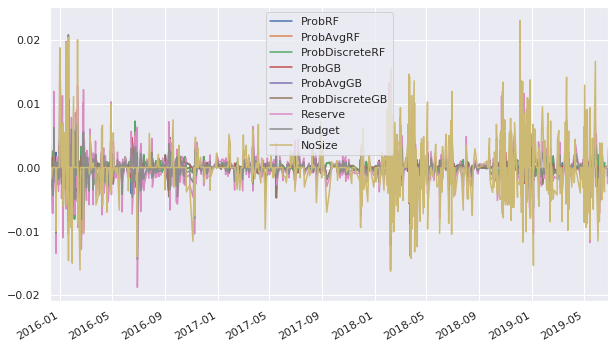

In [467]:
bet_profit.plot(figsize=(10,6))

누적수익률

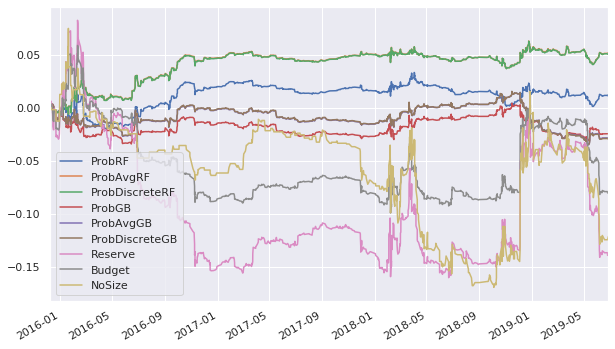

In [468]:
bet_profit.cumsum().plot(figsize=(10,6))

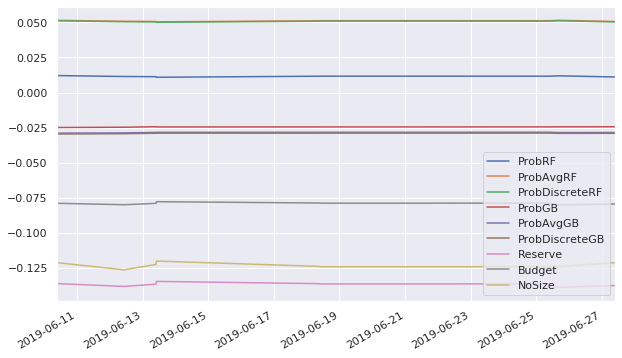

In [470]:
bet_profit.cumsum()[-10:].plot(figsize=(10,6))

평균수익률

In [471]:
bet_profit.mean()

ProbRF            0.000010
ProbAvgRF         0.000046
ProbDiscreteRF    0.000046
ProbGB           -0.000022
ProbAvgGB        -0.000026
ProbDiscreteGB   -0.000027
Reserve          -0.000126
Budget           -0.000073
NoSize           -0.000111
dtype: float64

Text(0.5, 1.0, 'Return Distribution(Reserve,Budget)')

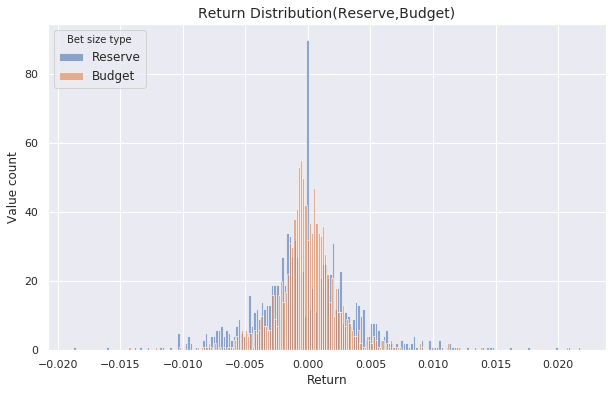

In [474]:
fig, ax = plt.subplots(figsize=(10,6))
for c in ['Reserve','Budget']:
    ax.hist(bet_profit[c],  label=c, alpha=0.6, bins=200)
ax.legend(loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax.set_xlabel("Return", fontsize=12)
ax.set_ylabel("Value count", fontsize=12)
ax.set_title("Return Distribution(Reserve,Budget)", fontsize=14)

Text(0.5, 1.0, 'Return Distribution (prob)')

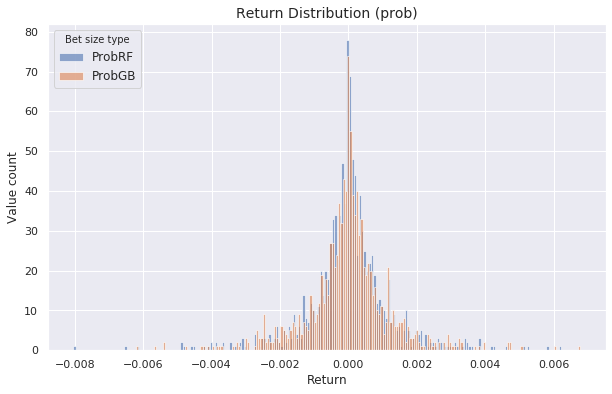

In [475]:
fig, ax = plt.subplots(figsize=(10,6))
for c in ['ProbRF','ProbGB']:
    ax.hist(bet_profit[c],  label=c, alpha=0.6, bins=200)
ax.legend(loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax.set_xlabel("Return", fontsize=12)
ax.set_ylabel("Value count", fontsize=12)fig, ax = plt.subplots(figsize=(10,6))
for c in ['ProbRF','ProbGB','Reserve','Budget']:
    ax.hist(bet_profit[c],  label=c, alpha=0.6, bins=200)
ax.legend(loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax.set_xlabel("Return", fontsize=12)
ax.set_ylabel("Value count", fontsize=12)
ax.set_title("Return Distribution", fontsize=14)
ax.set_title("Return Distribution (prob)", fontsize=14)

Text(0.5, 1.0, 'Return Distribution(no sizing)')

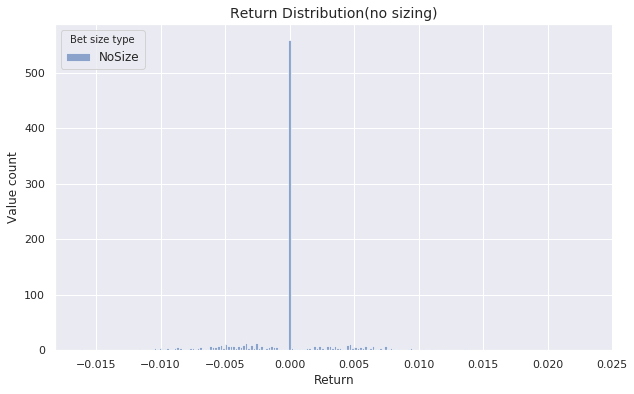

In [477]:
fig, ax = plt.subplots(figsize=(10,6))
for c in ['NoSize']:
    ax.hist(bet_profit[c],  label=c, alpha=0.6, bins=200)
ax.legend(loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax.set_xlabel("Return", fontsize=12)
ax.set_ylabel("Value count", fontsize=12)
ax.set_title("Return Distribution(no sizing)", fontsize=14)

In [478]:
print(X_train.index[0],'부터 ', X_train.index[-1],'까지의 틱 자료의 정보를 이용해', mret.index[0], '부터 ',mret.index[-1],'까지의 전략을 세웠다.','\n',
      '전략은 신호가 올 때 마다 t1까지 계산된 베팅 크기로 사거나 파는 행위를 하는 것이다. 예산은 무한하며 공매도가 가능하다고 가정한다.'
)

2009-11-09 11:21:44 부터  2015-12-09 10:10:44 까지의 틱 자료의 정보를 이용해 2015-12-09 10:30:59 부터  2019-06-27 09:54:36 까지의 전략을 세웠다. 
 전략은 신호가 올 때 마다 t1까지 계산된 베팅 크기로 사거나 파는 행위를 하는 것이다. 예산은 무한하며 공매도가 가능하다고 가정한다.


# 5. Backtesting

In [0]:
!pip install -q pyfolio
import pyfolio as pf

In [0]:
def get_daily_returns(intraday_returns):
    """
    This changes returns into daily returns that will work using pyfolio. Its not perfect...
    """
    
    cum_rets = ((intraday_returns + 1).cumprod())

    # Downsample to daily
    daily_rets = cum_rets.resample('B').last()

    # Forward fill, Percent Change, Drop NaN
    daily_rets = daily_rets.ffill().pct_change().dropna()
    
    return daily_rets

In [0]:
# Set-up the function to extract the KPIs from pyfolio
perf_func = pf.timeseries.perf_stats

### Bet Sizing (probability - meta-labeling)

rf

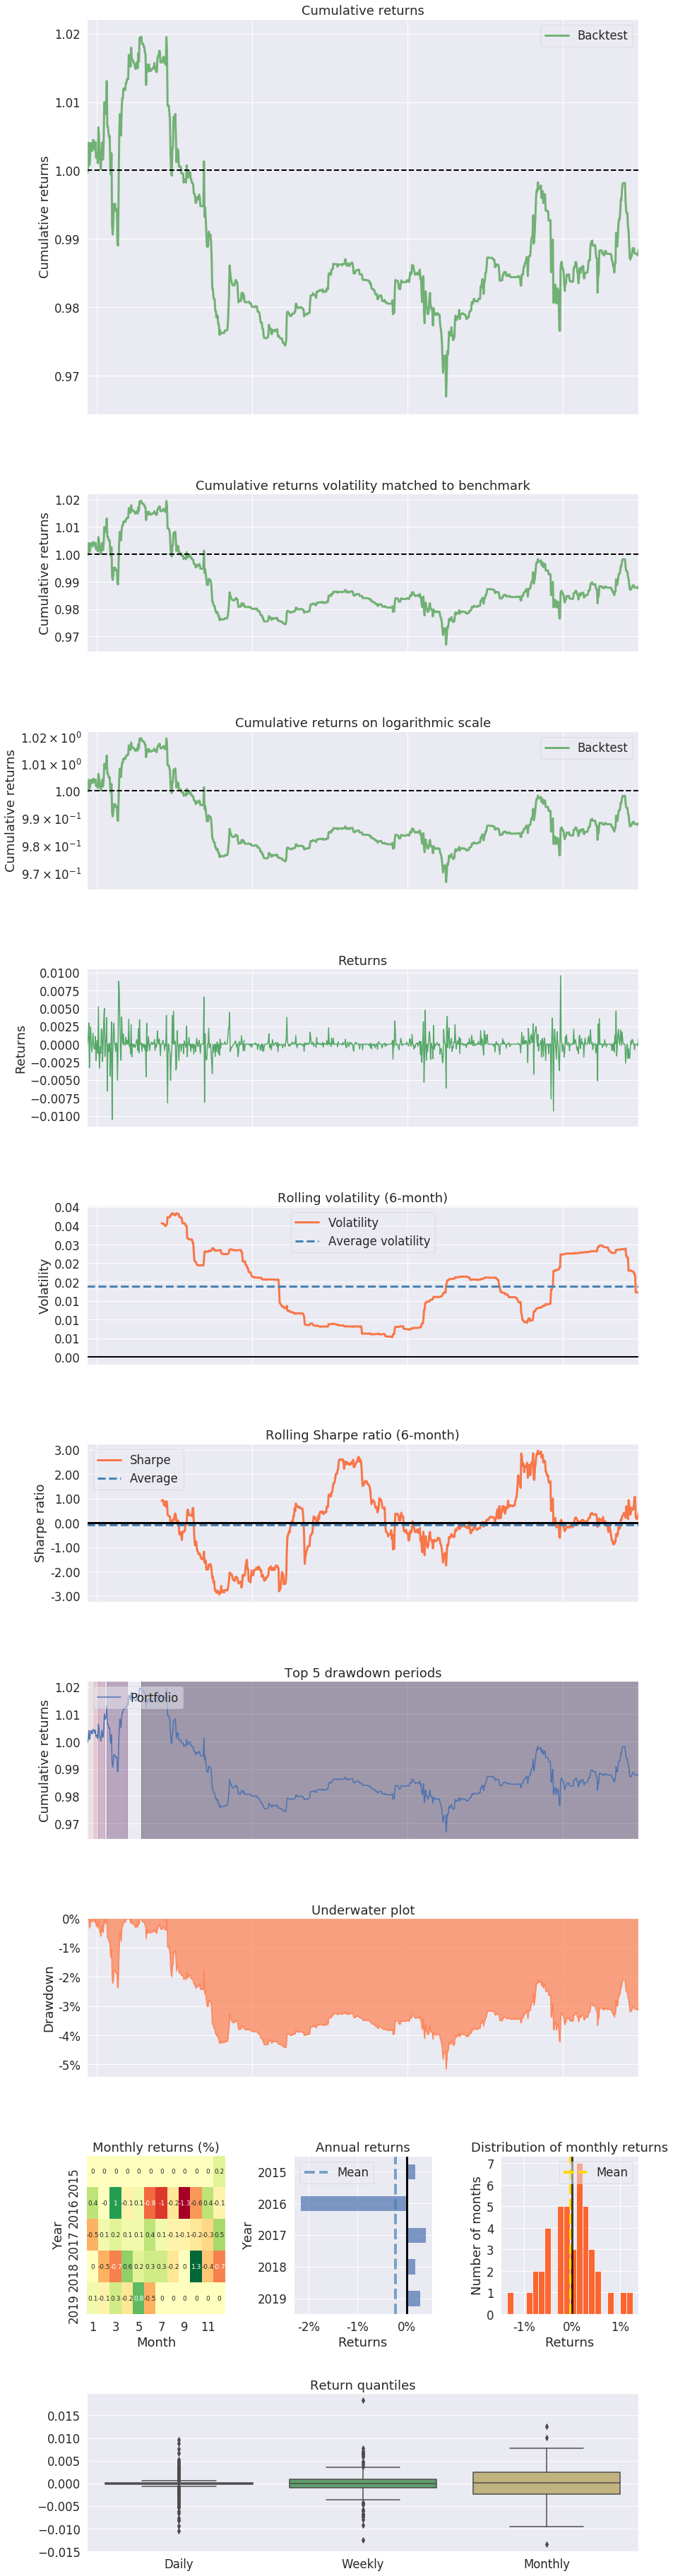

In [479]:
meta_returns = bin.loc[y_test.index, 'ret'] * mprob
daily_rets_meta = get_daily_returns(meta_returns)

pf.create_returns_tear_sheet(daily_rets_meta, benchmark_rets=None)

boosting

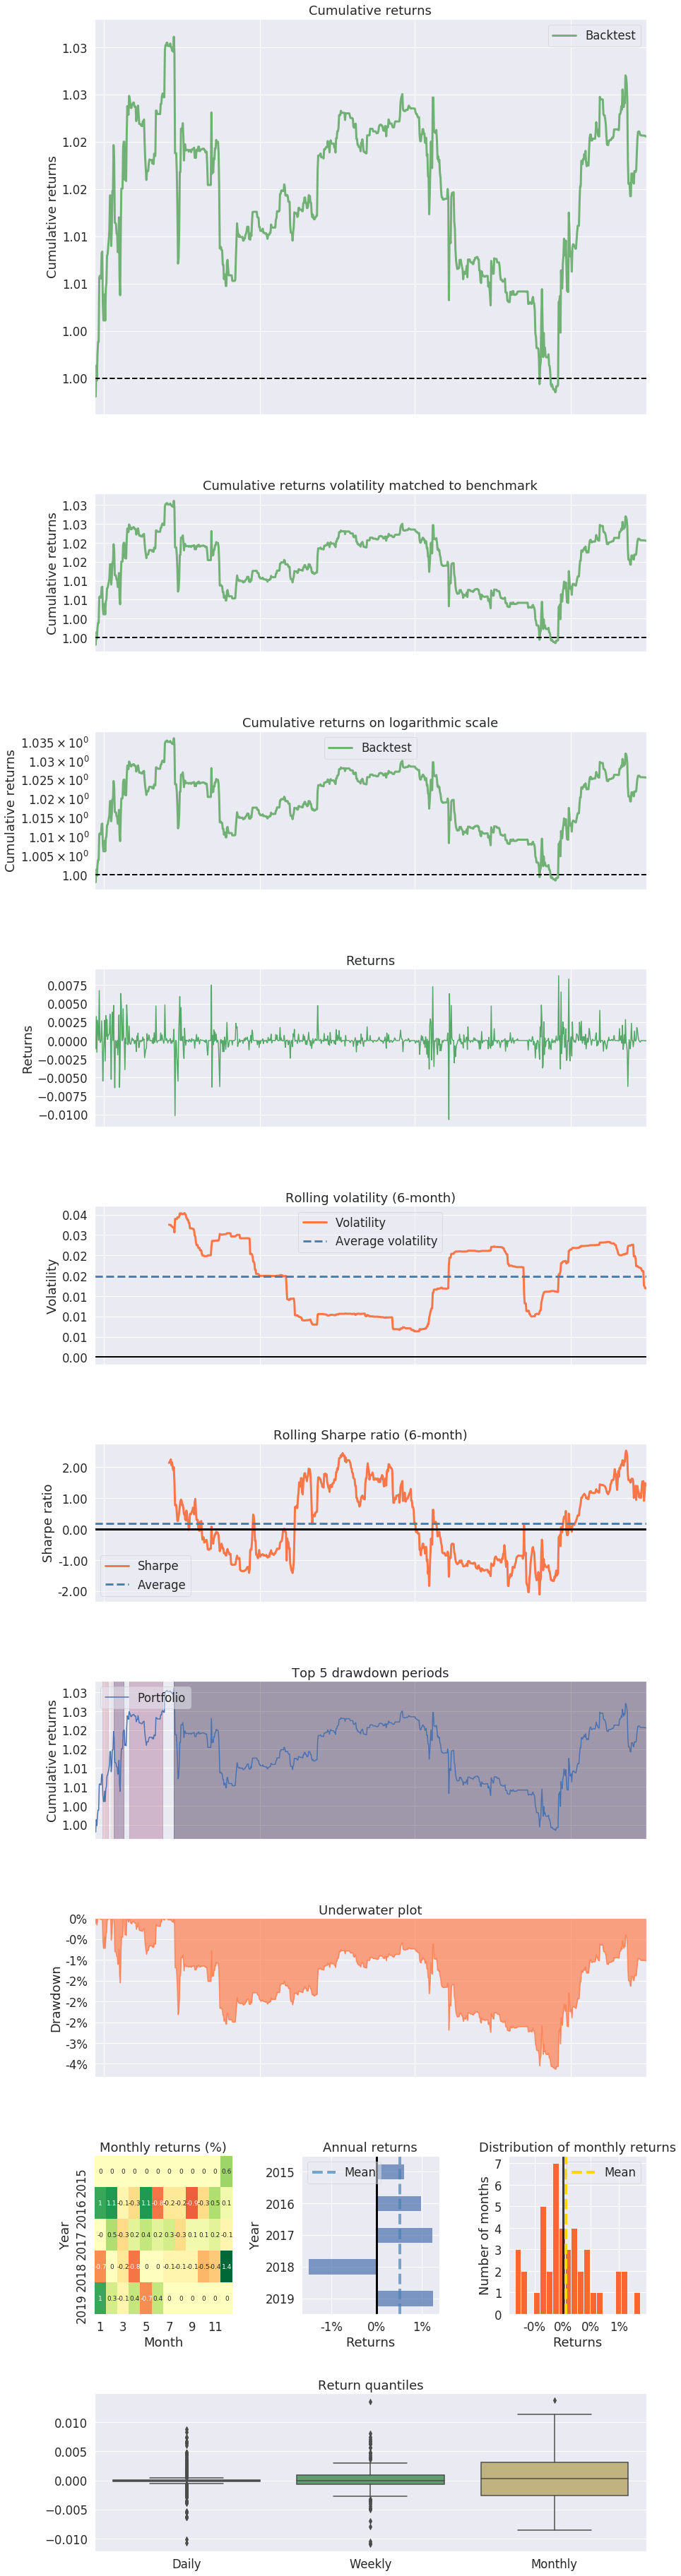

In [480]:
meta_returns = bin.loc[y_test.index, 'ret'] * mprob1
daily_rets_meta = get_daily_returns(meta_returns)

pf.create_returns_tear_sheet(daily_rets_meta, benchmark_rets=None)

#### Average

rf

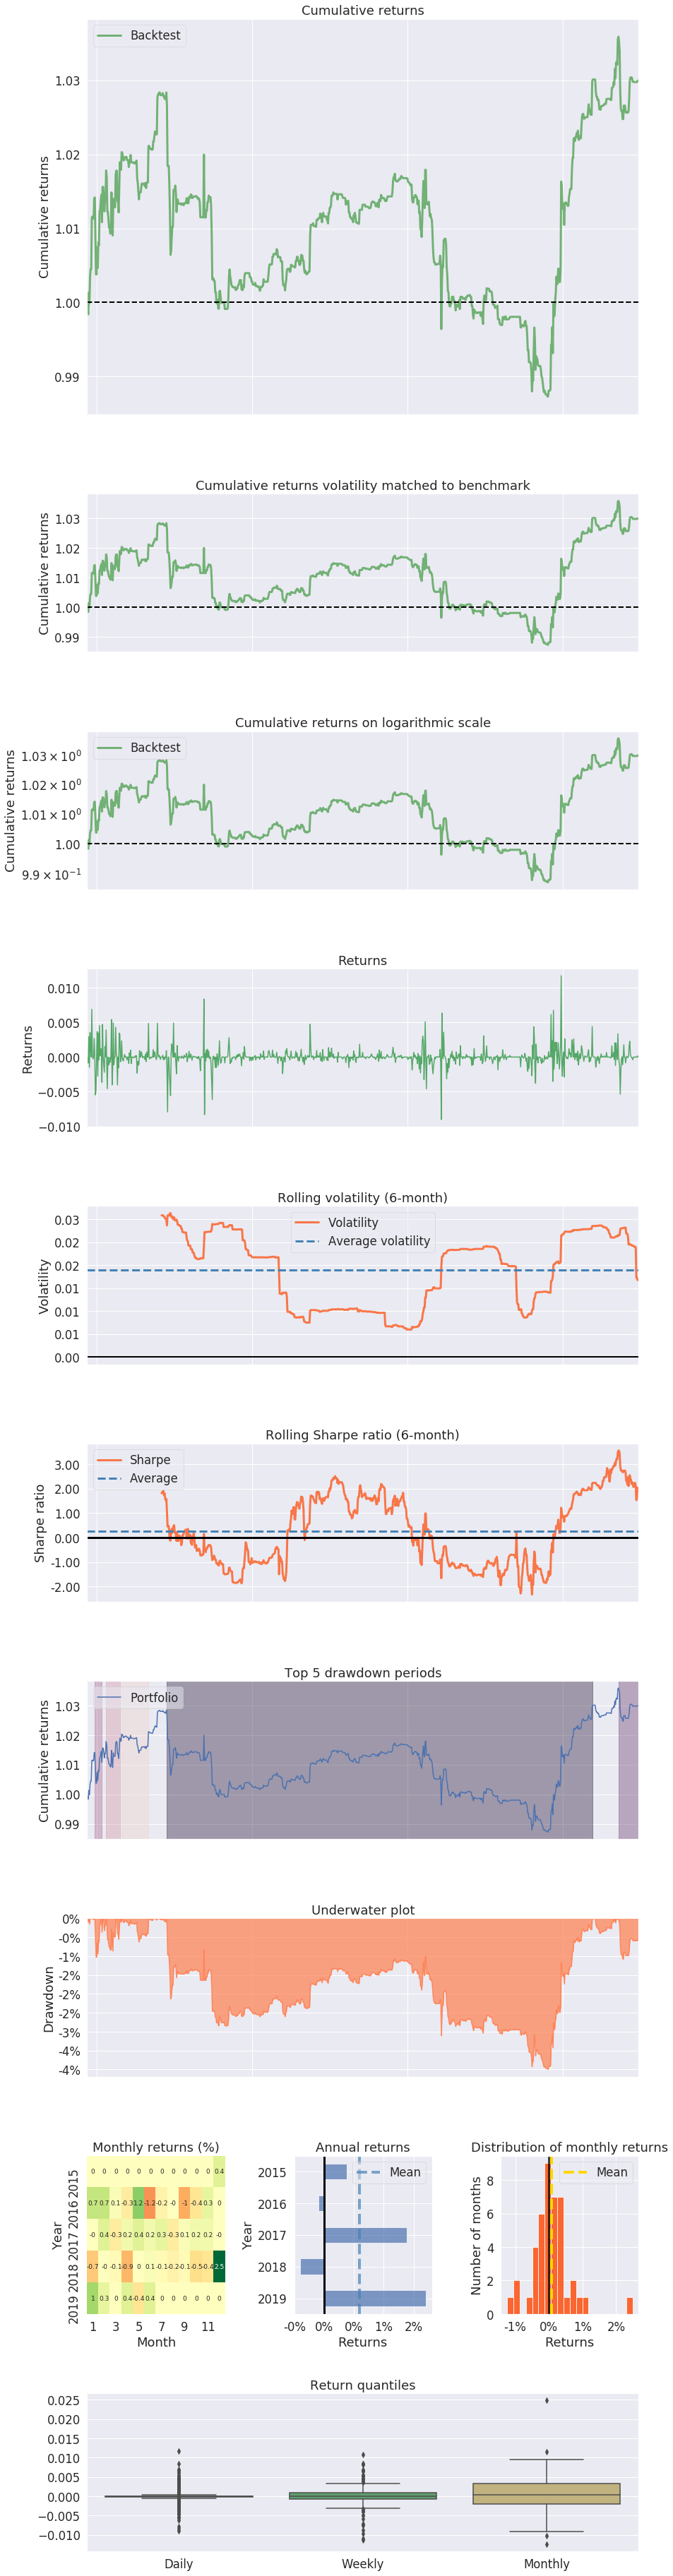

In [395]:
meta_returns = bin.loc[y_test.index, 'ret'] * mproba
daily_rets_meta = get_daily_returns(meta_returns)

pf.create_returns_tear_sheet(daily_rets_meta, benchmark_rets=None)

boosting

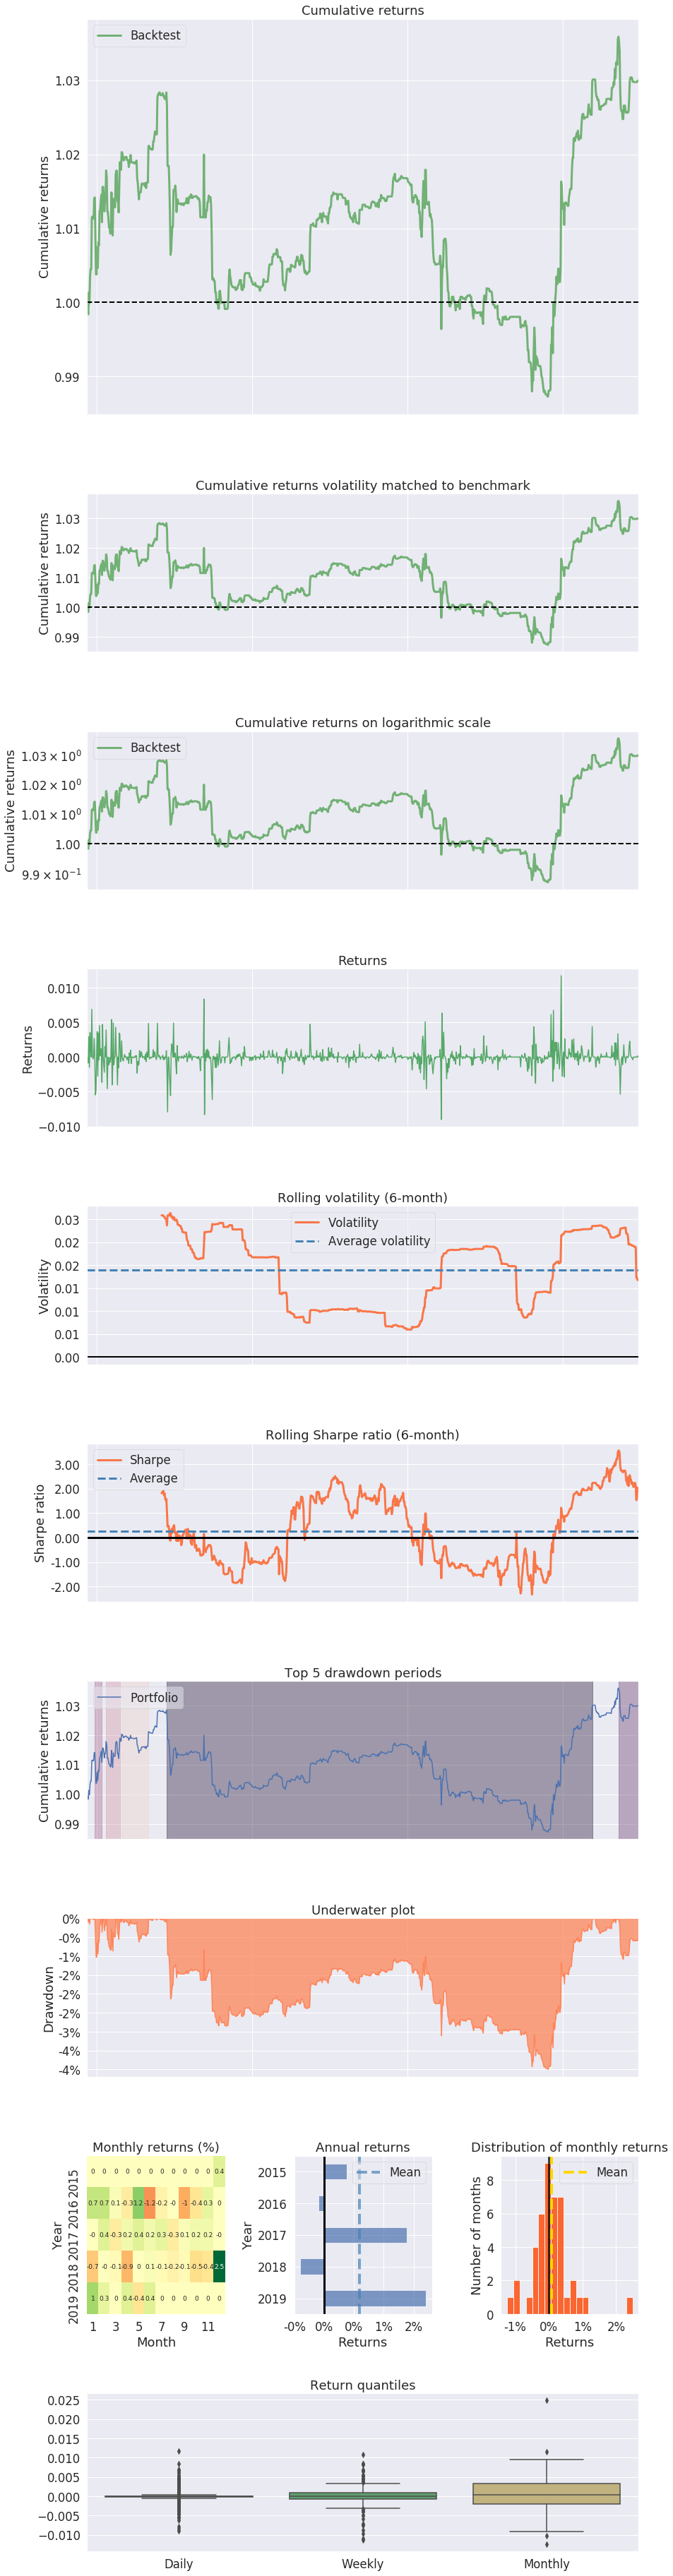

In [481]:
meta_returns = bin.loc[y_test.index, 'ret'] * mproba1
daily_rets_meta = get_daily_returns(meta_returns)

pf.create_returns_tear_sheet(daily_rets_meta, benchmark_rets=None)

#### Average Discrete

rf

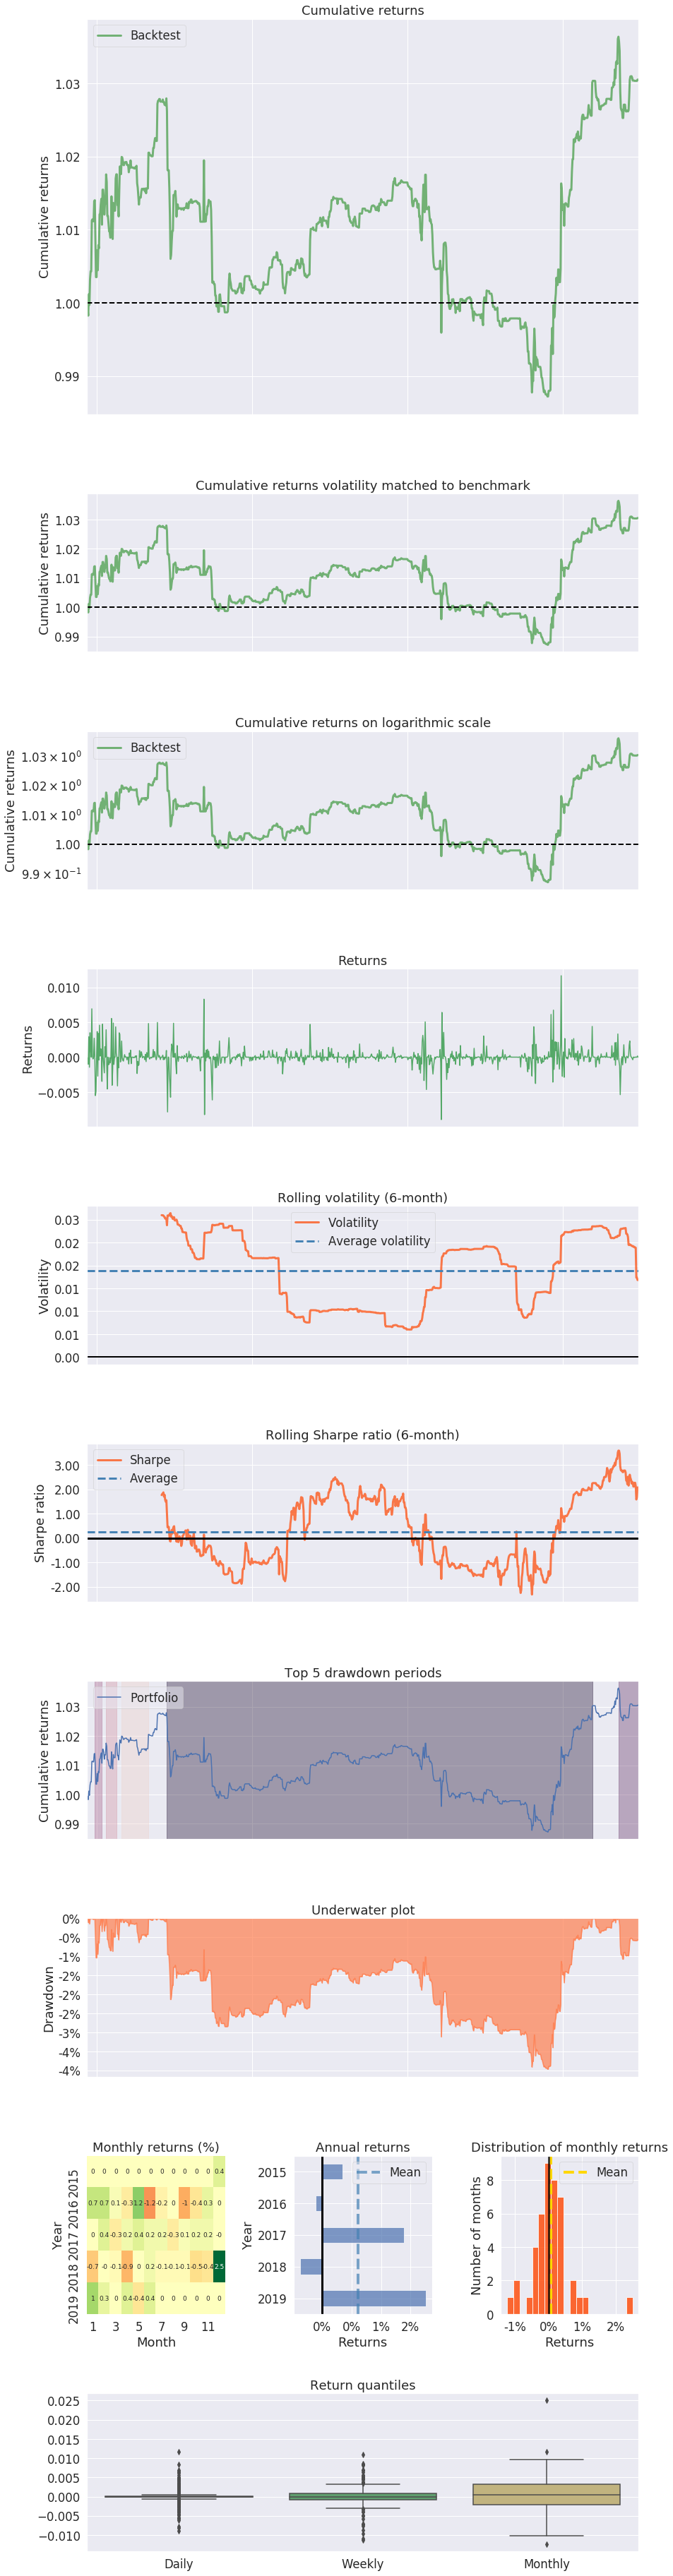

In [396]:
meta_returns = bin.loc[y_test.index, 'ret'] * mprobd
daily_rets_meta = get_daily_returns(meta_returns)

pf.create_returns_tear_sheet(daily_rets_meta, benchmark_rets=None)

boosting

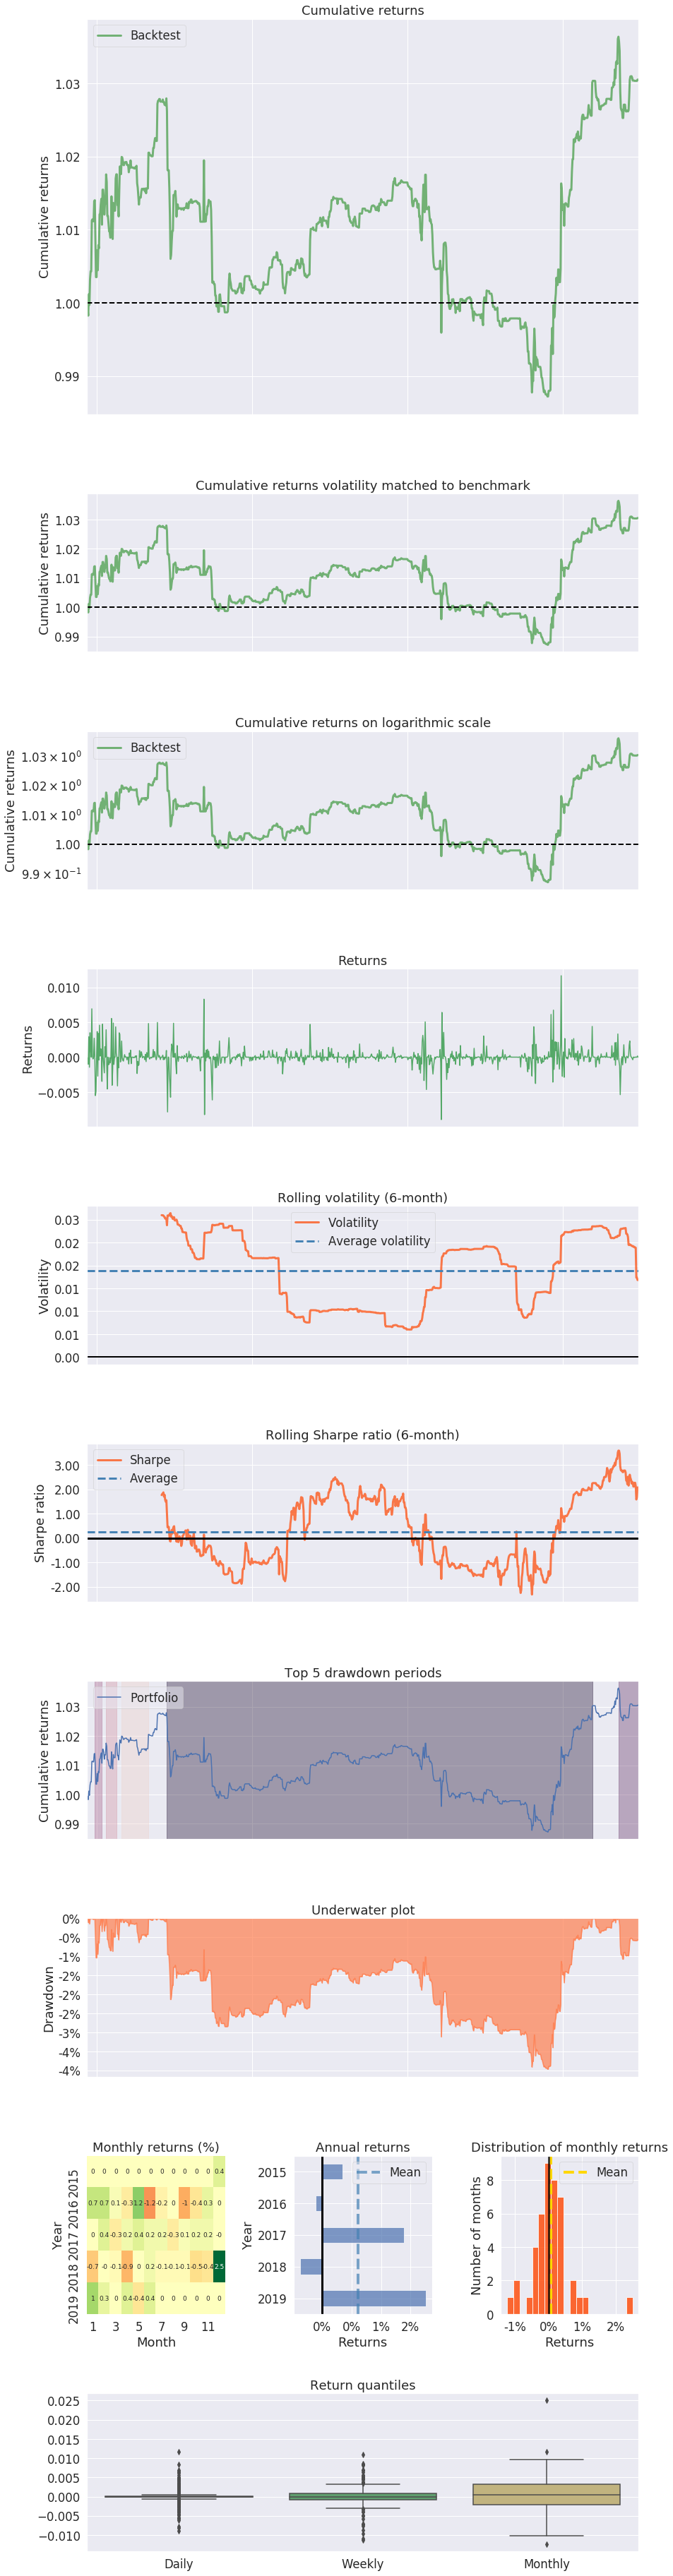

In [482]:
meta_returns = bin.loc[y_test.index, 'ret'] * mprobd1
daily_rets_meta = get_daily_returns(meta_returns)

pf.create_returns_tear_sheet(daily_rets_meta, benchmark_rets=None)

### Bet Sizing (reserve - 2GMM)

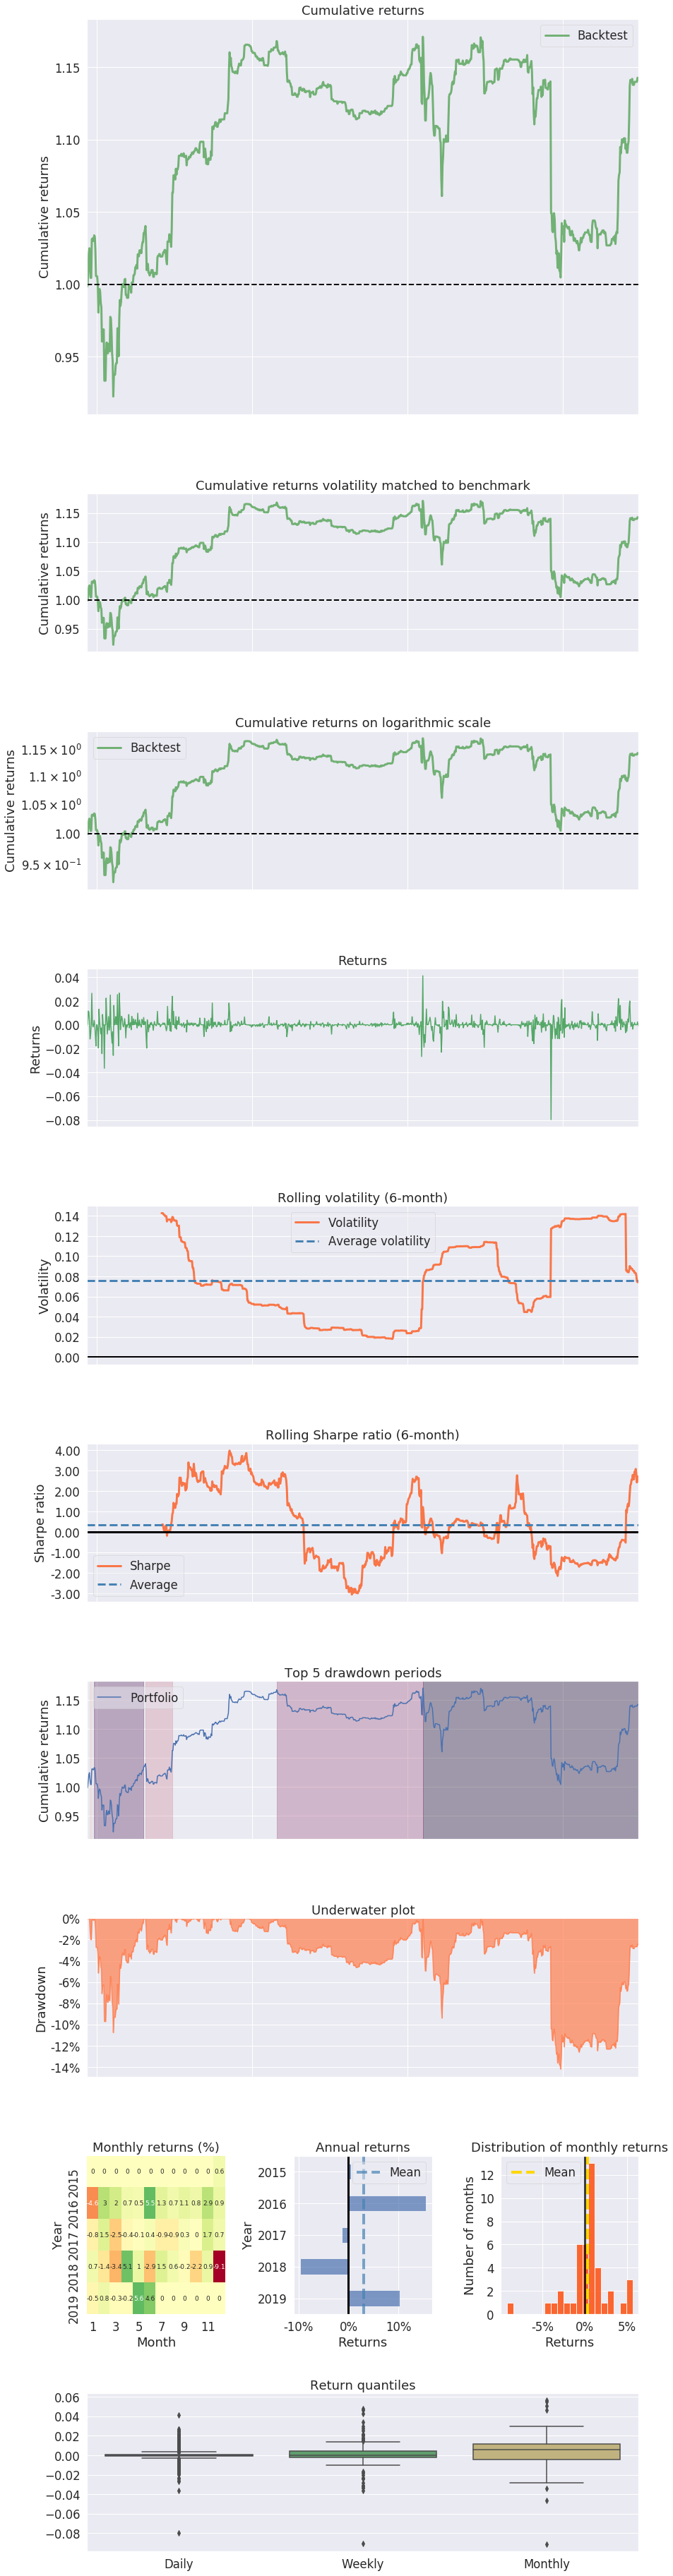

In [397]:
meta_returns = bin.loc[y_test.index, 'ret'] * mres
daily_rets_meta = get_daily_returns(meta_returns)

pf.create_returns_tear_sheet(daily_rets_meta, benchmark_rets=None)

### Bet Sizing (budget)

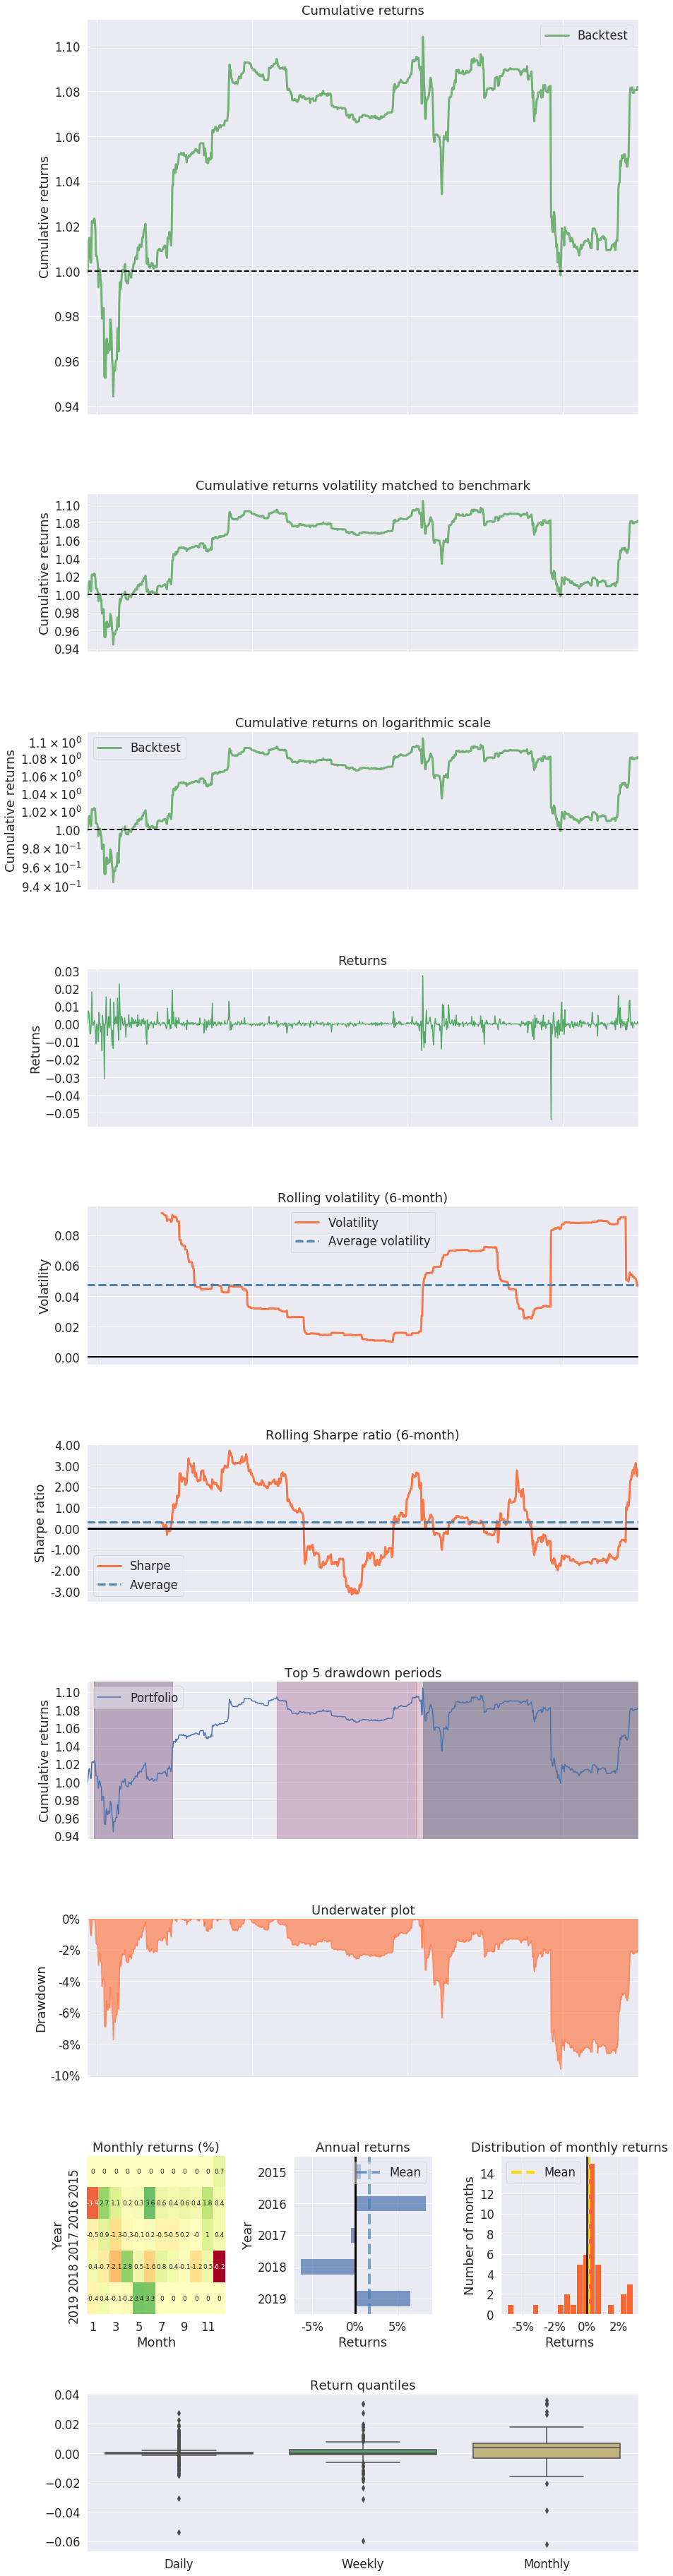

In [398]:
meta_returns = bin.loc[y_test.index, 'ret'] * mbudg
daily_rets_meta = get_daily_returns(meta_returns)

pf.create_returns_tear_sheet(daily_rets_meta, benchmark_rets=None)

### No Sizing (side*size(binary))

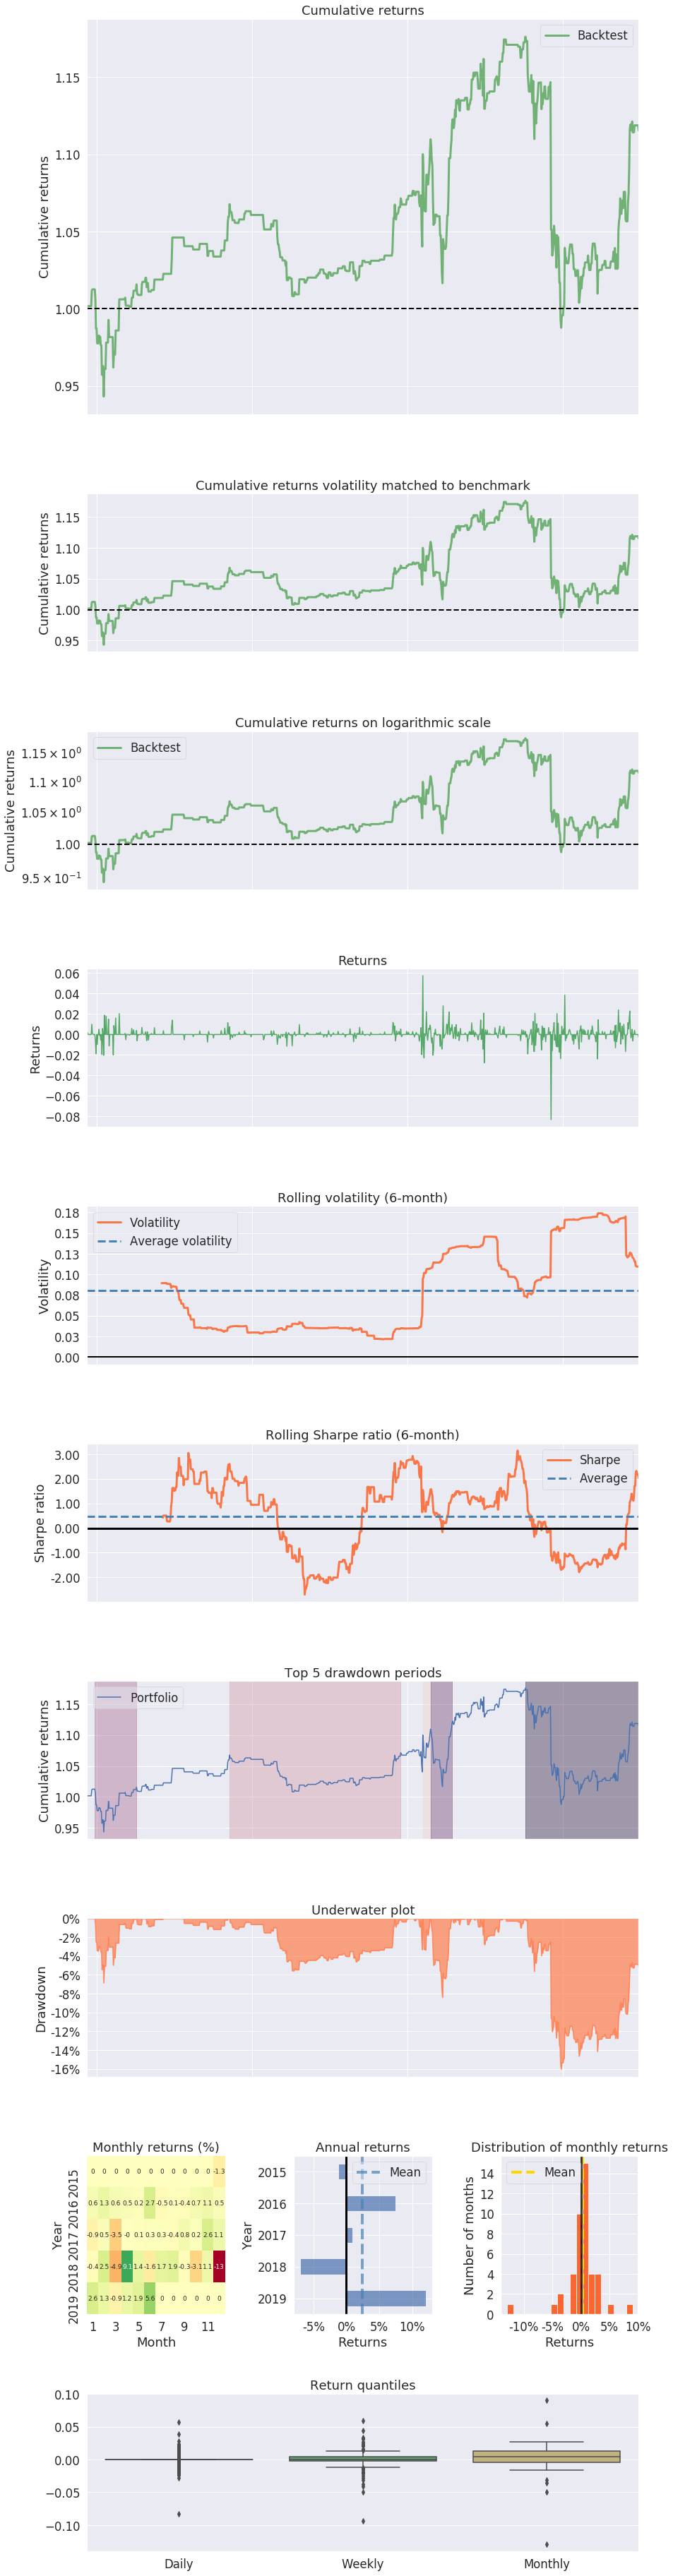

In [399]:
meta_returns = bin.loc[y_test.index, 'ret'] * mnosize
daily_rets_meta = get_daily_returns(meta_returns)

pf.create_returns_tear_sheet(daily_rets_meta, benchmark_rets=None)

# REFERENCE

Marcos Lopez de Prado. Advances in Financial Machine Learning. Wiley, 2018

https://github.com/hudson-and-thames/research

Marcos Lopez de Prado and Matthew D. Foreman. “A mixture of Gaussians approach to mathematical portfolio oversight: the EF3M algorithm”. In: Quantitative Finance14.5 (2014), pp. 913–930.

Yakup Kara
, Melek Acar Boyacioglu 
, Ömer Kaan Baykan. "Predicting direction of stock price index movement using artificial neural
networks and support vector machines: The sample of the Istanbul Stock Exchange"


https://scikit-learn.org/stable/modules/svm.html#scores-and-probabilities

s/o to mlfinlab, ta, pyfolio